<a href="https://colab.research.google.com/github/MorrisWan/Adversarial-Attacks-on-Applied-CNN/blob/master/Traffic_Light_Distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
 import tensorflow as tf
import numpy as np
import os
import pickle
import gzip
import urllib.request

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras.optimizers import SGD
def train(X_data, Y_data, file_name, num_epochs=50, batch_size=128, train_temp=1, init=None):
    """
    Standard neural network training procedure.
    """
    model = Sequential()

    print(X_data.shape)
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(3))
    if init != None:
        model.load_weights(init)
    # compile model
    opt = SGD(lr=0.001, momentum=0.9)
    def fn(correct, predicted):
        return tf.nn.softmax_cross_entropy_with_logits(labels=correct,
                                                       logits=predicted/train_temp)
    model.compile(optimizer=opt, loss=fn,metrics=['accuracy'])
    model.fit(X_data, Y_data,batch_size=50,epochs= num_epochs, validation_split = 0.3)
    if file_name != None:
        model.save(file_name)
  

    return model


Using TensorFlow backend.


In [0]:
def train_distillation(X_data, Y_data, file_name, num_epochs=50, batch_size=50, train_temp=1):
    """
    Train a network using defensive distillation.
    Distillation as a Defense to Adversarial Perturbations against Deep Neural Networks
    Nicolas Papernot, Patrick McDaniel, Xi Wu, Somesh Jha, Ananthram Swami
    IEEE S&P, 2016.
    """
    if not os.path.exists(file_name+"_init"):
        # Train for one epoch to get a good starting point.
        train(X_data, Y_data, file_name+"_init", 1, batch_size)
    
    # now train the teacher at the given temperature
    teacher = train(X_data, Y_data, file_name+"_teacher", num_epochs, batch_size, train_temp, init=file_name+"_init")

    # evaluate the labels at temperature t
    predicted = teacher.predict(X_data)
    with tf.Session() as sess:
        y = sess.run(tf.nn.softmax(predicted/train_temp))
        print(y)
        Y_data = y

    # train the student model at temperature t
    student = train(X_data, Y_data, file_name, num_epochs, batch_size, train_temp,
                    init=file_name+"_init")

    # and finally we predict at temperature 1
    predicted = student.predict(X_data)

    print(predicted)
    return student
    
if not os.path.isdir('models'):
    os.makedirs('models')

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from google.colab import drive #08/26/2019 Morris Wan
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/'
from tqdm import tqdm
seed = 7
np.random.seed(seed)
from PIL import Image
import yaml
def crop(image_path, coords, saved_location):
    """
    @param image_path: The path to the image to edit
    @param coords: A tuple of x/y coordinates (x1, y1, x2, y2)
    @param saved_location: Path to save the cropped image
    """
    image_obj = Image.open(image_path)
    cropped_image = image_obj.crop(coords)
    cropped_image.save(saved_location)
    cropped_image.show()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
rootpath = 'gdrive/My Drive/Traffic Light Images/'
IMG_SIZE = 32
x_width = 0
y_heigth = 0
xmin = 0
ymin = 0
label = 0
training_data_traffic = []
training_labels_traffic = []
stream = open('gdrive/My Drive/real_data_annotations.yaml', 'r')
dictionary = yaml.load(stream)
i = 0
for value in dictionary:
  for key, val in value.items():
    if key == 'filename':
      path = os.path.join(rootpath, val)
      for key,val in value.items():
        if key =='annotations':
          for va in val:
            for key, val in va.items():
              if key == 'x_width':
                 x_width = val
              if key == 'xmin':
                 xmin = val
              if key == 'y_height':
                 y_height = val
              if key == 'ymin':
                 ymin = val
              if key == 'class':
                if val == 'Green':
                  label = [1, 0, 0]
                elif val == 'Yellow':
                  label = [0, 1, 0]
                else:
                  label = [0, 0, 1]
        crop(path, (xmin, ymin, xmin + x_width, ymin + y_height), 'cropped.jpg')
        try:
              img_array = cv2.imread(os.path.join('cropped.jpg'))
              new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
              training_data_traffic.append([new_array,label])
        except Exception as e:
          pass

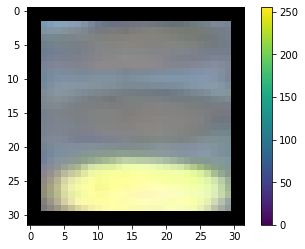

(319, 32, 32, 3)
(158, 32, 32, 3)
319
158


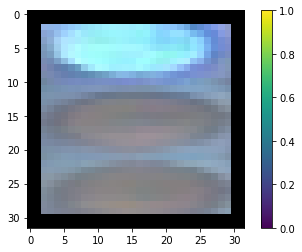

[0, 0, 1]


In [0]:
from sklearn.model_selection import train_test_split
X = []
Y = []

for feature,label in training_data_traffic:
    X.append(feature)
    Y.append(label)
i = 0
j = 0
while j < len(X):
  for i in range(32):
    X[j][0][i] = 0
  for i in range(32):
    X[j][31][i] = 0
  for i in range(32):
    X[j][1][i] = 0
  for i in range(32):
    X[j][30][i] = 0
  for i in range(32):
    X[j][i][0] = 0
  for i in range(32):
    X[j][i][31] = 0
  for i in range(32):
    X[j][i][30] = 0
  for i in range(32):
    X[j][i][1] = 0
  j += 1
plt.figure()
plt.imshow(X[0])
plt.colorbar()
plt.grid(False)
plt.show()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=seed)
X_train = np.array(X_train).reshape( -1, IMG_SIZE, IMG_SIZE, 3)
X_train = X_train/255.0
X_test = np.array(X_test).reshape(-1,IMG_SIZE, IMG_SIZE, 3)
X_test = X_test/255.0
print(X_train.shape)
print(X_test.shape)
print(len(Y_train))
print(len(Y_test))
plt.figure()
plt.imshow(X_test[99])
plt.colorbar()
plt.grid(False)
plt.show()
print(Y_test[99])
class_names = ['green', 'yellow', 'red']

In [0]:
model = train(X_train,np.array(Y_train), os.path.join(root_path, 'test_model.pt'), num_epochs = 5, batch_size = 50)


(319, 32, 32, 3)




Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.




Train on 223 samples, validate on 96 samples
Epoch 1/5





223/223 [==============================] - 2s 8ms/step - loss: 1.0185 - acc: 0.5381 - val_loss: 0.3758 - val_acc: 0.7604
Epoch 2/5
223/223 [==============================] - 1s 3ms/step - loss: 0.2510 - acc: 0.9103 - val_loss: 0.0475 - val_acc: 1.0000
Epoch 3/5
223/223 [==============================] - 1s 3ms/step - loss: 0.0728 - acc: 0.9955 - val_loss: 0.0096 - val_acc: 1.0000
Epoch 4/5
223/223 [==============================] - 1s 3ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 0.0124 - val_acc: 1.0000
Epoch 5/5
223/223 [==============================] - 1s 3ms/step - loss: 0.0100 - acc: 1.0000 - val_loss: 0.0062 - val_acc: 1.0000


In [0]:
def test_array_for_model(array):
  thing = []
  thing.append(array)
  thing = np.array(thing).reshape(-1,32, 32, 3)
  return thing
print(model.predict(test_array_for_model(X_test[0])))
print(Y_test[0])

[[-4.068881  -2.8175607  2.0822802]]
[0, 0, 1]


In [0]:
train(X_train, np.array(Y_train), os.path.join(root_path, 'model.pt'), num_epochs = 3, batch_size = 50)
robust_model = train_distillation(X_train, np.array(Y_train), os.path.join(root_path, 'Distilled_Model.pt'), num_epochs = 3, train_temp = 100)


(319, 32, 32, 3)




Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.




Train on 223 samples, validate on 96 samples
Epoch 1/3





223/223 [==============================] - 2s 7ms/step - loss: 1.0186 - acc: 0.5381 - val_loss: 0.3758 - val_acc: 0.7604
Epoch 2/3
223/223 [==============================] - 1s 3ms/step - loss: 0.2509 - acc: 0.9103 - val_loss: 0.0476 - val_acc: 1.0000
Epoch 3/3
223/223 [==============================] - 1s 3ms/step - loss: 0.0728 - acc: 0.9955 - val_loss: 0.0096 - val_acc: 1.0000
(319, 32, 32, 3)
Train on 223 samples, validate on 96 samples
Epoch 1/1
223/223 [==============================] - 1s 4ms/step - loss: 0.9343 - acc: 0.6188 - val_loss: 0.6236 - val_acc: 1.0000
(319, 32, 32, 3)
Train on 223 samples, validate on 96 samples
Epoch 1/3
223/223 [==============================] - 1s 4ms/step - loss: 1.0925 - acc:

In [0]:
def test_array_for_model(array):
  thing = []
  thing.append(array)
  thing = np.array(thing).reshape(-1,32, 32, 3)
  return thing


In [0]:
!pip install foolbox
!pip install randomgen

     |████████████████████████████████| 1.9MB 4.8MB/s 
     |████████████████████████████████| 460kB 48.4MB/s 
     |████████████████████████████████| 71kB 8.5MB/s 
  Created wheel for foolbox: filename=foolbox-2.2.1-cp36-none-any.whl size=1925325 sha256=c65d81a9e61fefe0264a2f94a87e4b3fa33cd774e4fe552e2d844962d37ee11e
  Stored in directory: /root/.cache/pip/wheels/ad/e0/d0/7c816d84eeb9ef167f91a71f31cc37c541c4af62e8ca5e8227
Successfully built foolbox
     |████████████████████████████████| 2.1MB 5.0MB/s 


In [0]:
import foolbox
from foolbox.attacks import CarliniWagnerL2Attack
from foolbox.criteria import TargetClassProbability
test_labels = []
count = 0
while count < len(Y_test):
  test_labels.append(np.argmax(Y_test[count]))
  count += 1

fmodel = foolbox.models.KerasModel(robust_model, bounds=(0, 1), preprocessing=(0,1), predicts = 'logits')
attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)
adversarial2 = attack(test_array_for_model(X_test), np.array(test_labels))

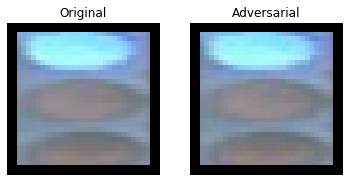

[0, 0, 1]
1


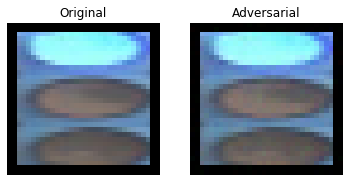

[0, 0, 1]
2


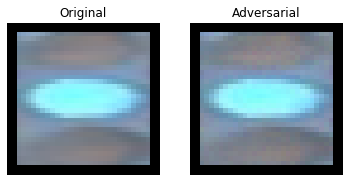

[0, 1, 0]
3


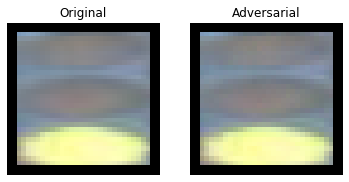

[1, 0, 0]
4


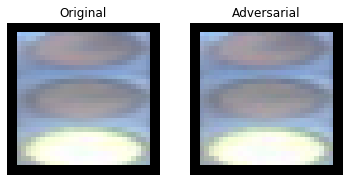

[1, 0, 0]
5


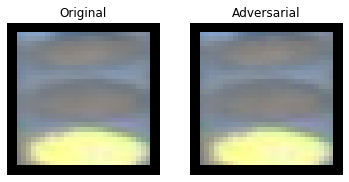

[1, 0, 0]
6


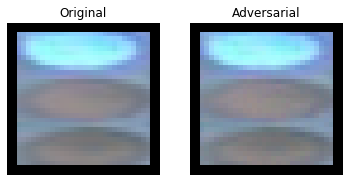

[0, 0, 1]
7


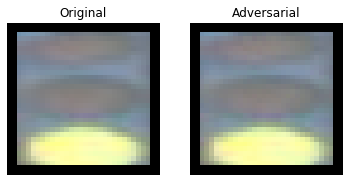

[1, 0, 0]
8


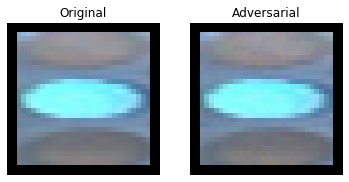

[0, 1, 0]
9


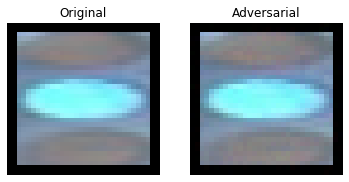

[0, 1, 0]
10


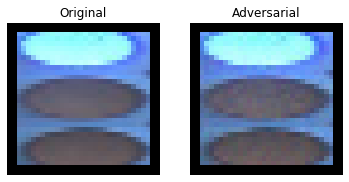

[0, 0, 1]
11


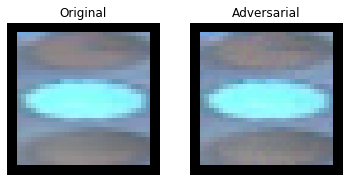

[0, 1, 0]
12


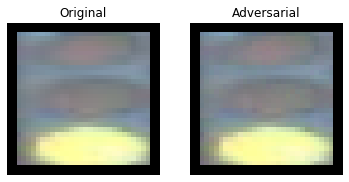

[1, 0, 0]
13


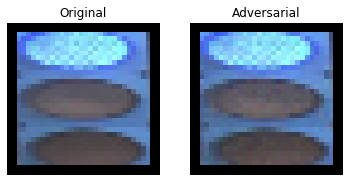

[0, 0, 1]
14


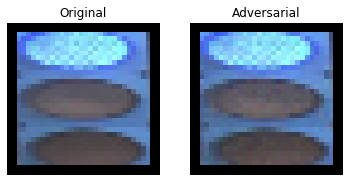

[0, 0, 1]
15


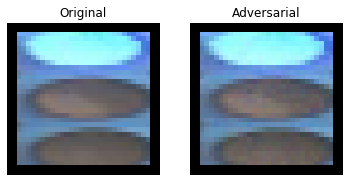

[0, 0, 1]
16


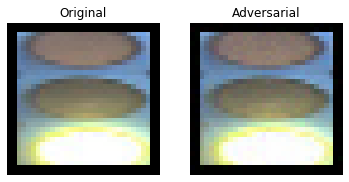

[1, 0, 0]
17


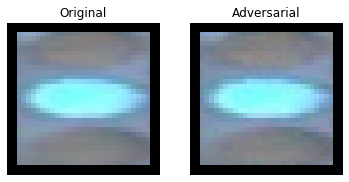

[0, 1, 0]
18


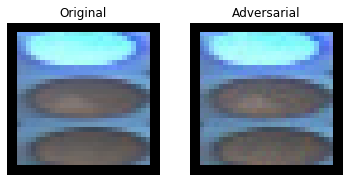

[0, 0, 1]
19


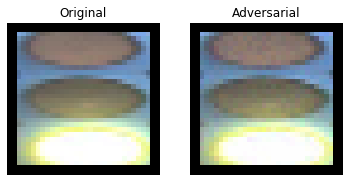

[1, 0, 0]
20


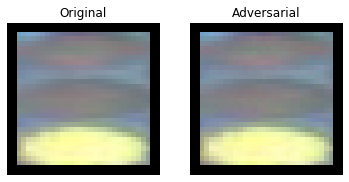

[1, 0, 0]
21


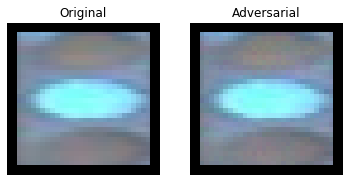

[0, 1, 0]
22


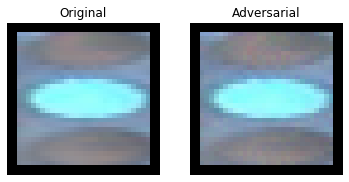

[0, 1, 0]
23


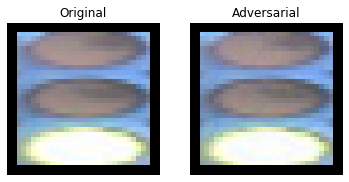

[1, 0, 0]
24


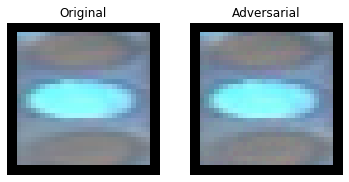

[0, 1, 0]
25


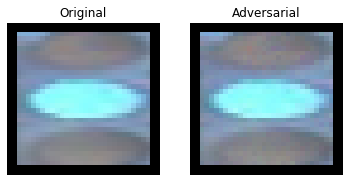

[0, 1, 0]
26


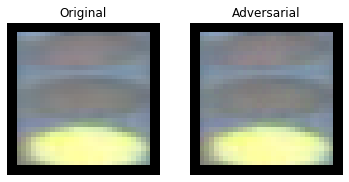

[1, 0, 0]
27


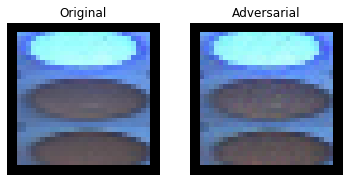

[0, 0, 1]
28


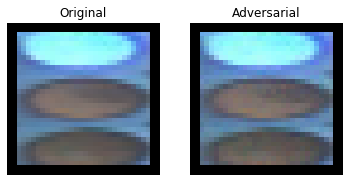

[0, 0, 1]
29


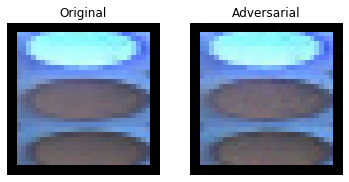

[0, 0, 1]
30


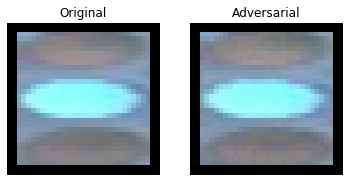

[0, 1, 0]
31


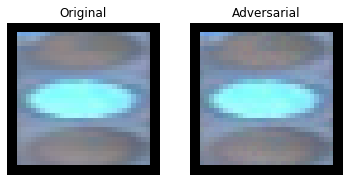

[0, 1, 0]
32


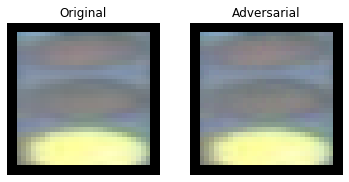

[1, 0, 0]
33


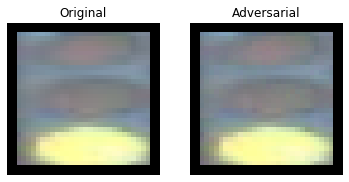

[1, 0, 0]
34


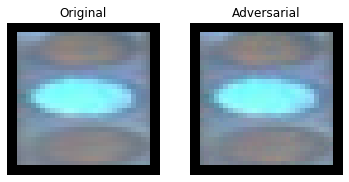

[0, 1, 0]
35


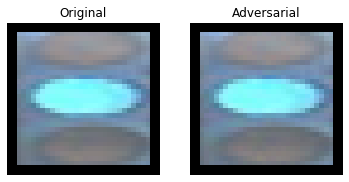

[0, 1, 0]
36


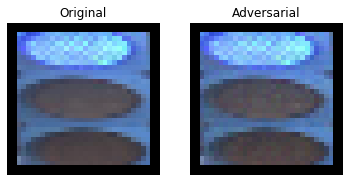

[0, 0, 1]
37


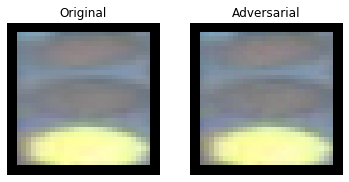

[1, 0, 0]
38


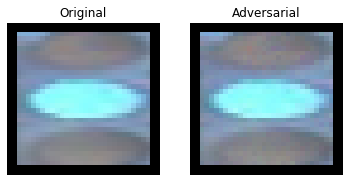

[0, 1, 0]
39


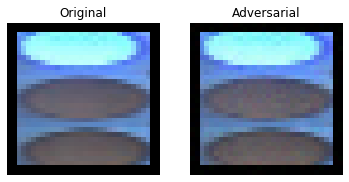

[0, 0, 1]
40


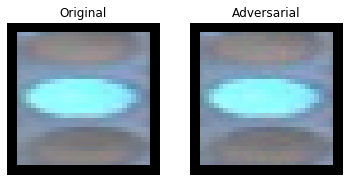

[0, 1, 0]
41


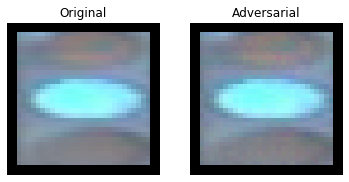

[0, 1, 0]
42


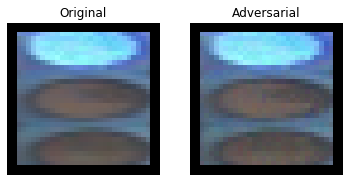

[0, 0, 1]
43


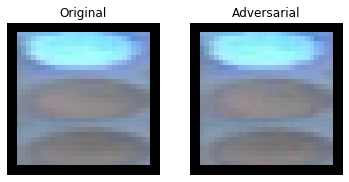

[0, 0, 1]
44


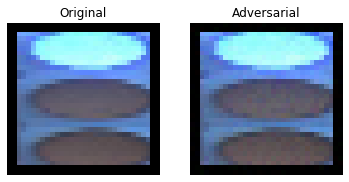

[0, 0, 1]
45


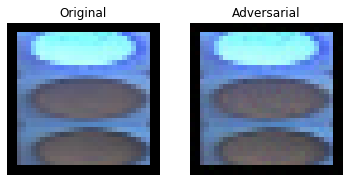

[0, 0, 1]
46


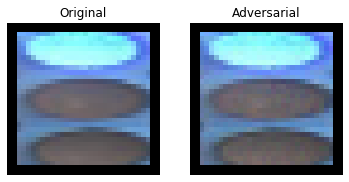

[0, 0, 1]
47


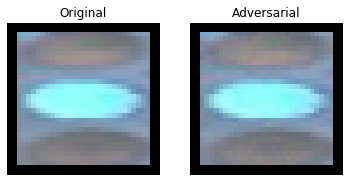

[0, 1, 0]
48


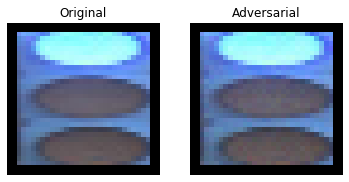

[0, 0, 1]
49


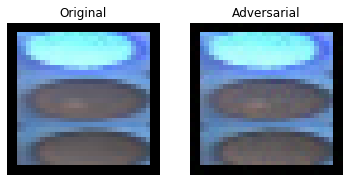

[0, 0, 1]
50


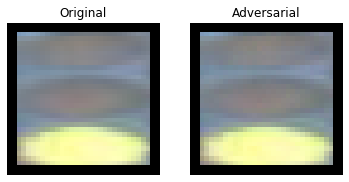

[1, 0, 0]
51


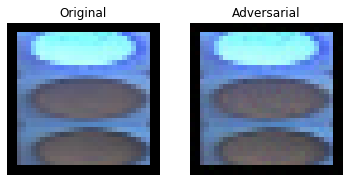

[0, 0, 1]
52


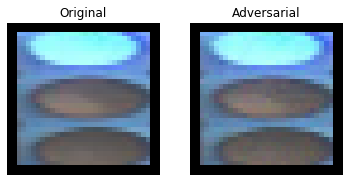

[0, 0, 1]
53


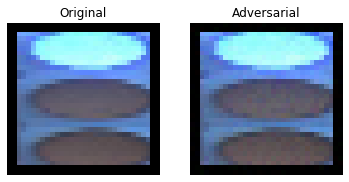

[0, 0, 1]
54


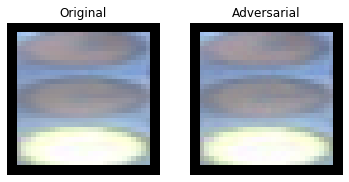

[1, 0, 0]
55


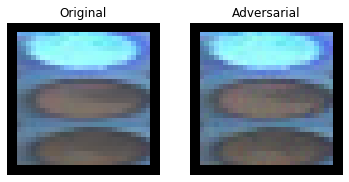

[0, 0, 1]
56


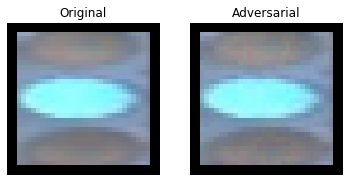

[0, 1, 0]
57


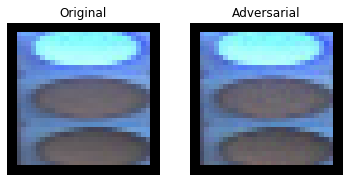

[0, 0, 1]
58


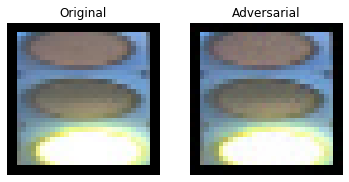

[1, 0, 0]
59


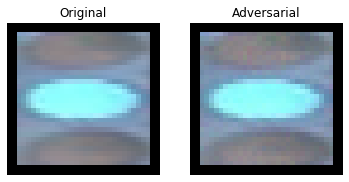

[0, 1, 0]
60


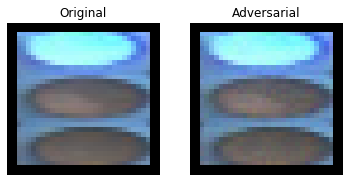

[0, 0, 1]
61


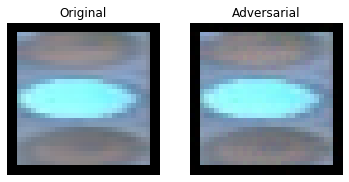

[0, 1, 0]
62


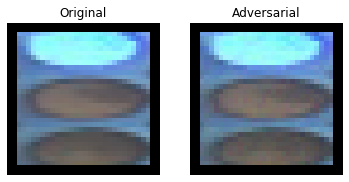

[0, 0, 1]
63


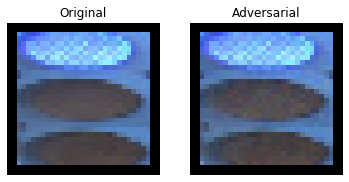

[0, 0, 1]
64


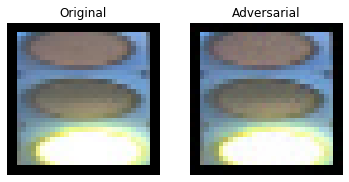

[1, 0, 0]
65


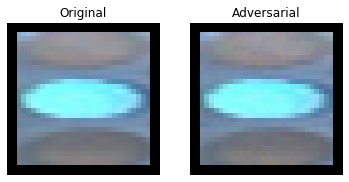

[0, 1, 0]
66


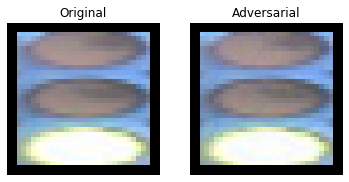

[1, 0, 0]
67


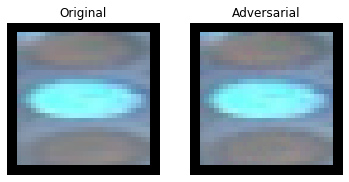

[0, 1, 0]
68


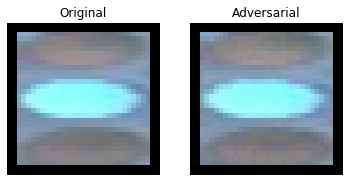

[0, 1, 0]
69


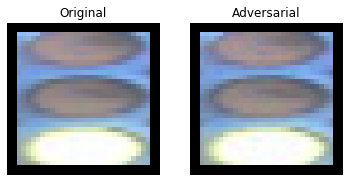

[1, 0, 0]
70


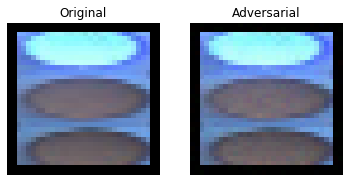

[0, 0, 1]
71


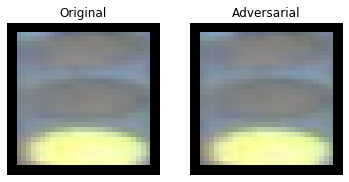

[1, 0, 0]
72


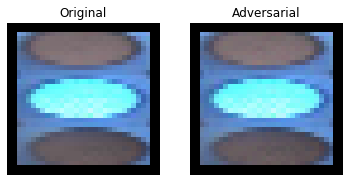

[0, 1, 0]
73


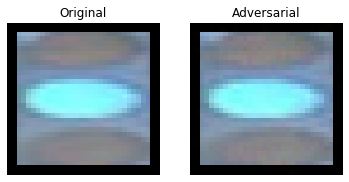

[0, 1, 0]
74


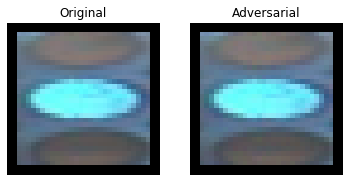

[0, 1, 0]
75


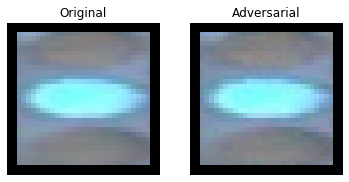

[0, 1, 0]
76


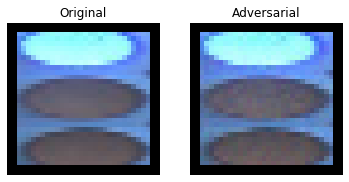

[0, 0, 1]
77


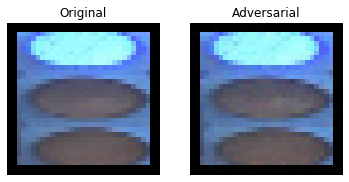

[0, 0, 1]
78


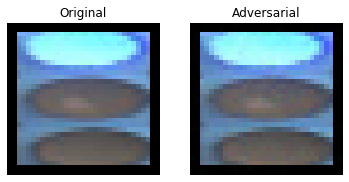

[0, 0, 1]
79


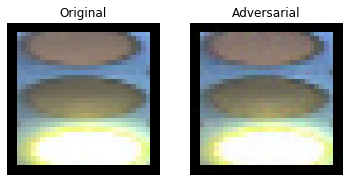

[1, 0, 0]
80


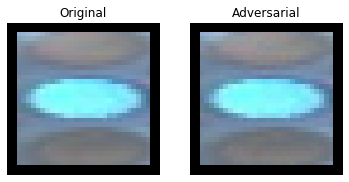

[0, 1, 0]
81


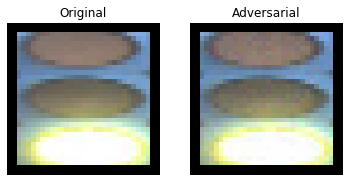

[1, 0, 0]
82


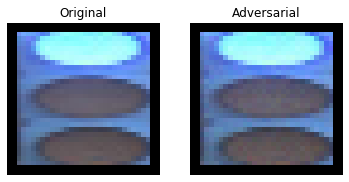

[0, 0, 1]
83


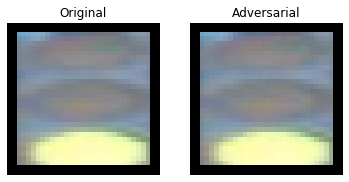

[1, 0, 0]
84


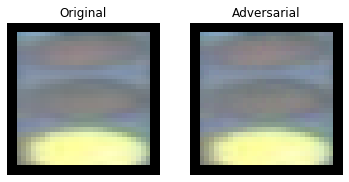

[1, 0, 0]
85


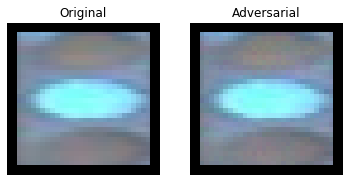

[0, 1, 0]
86


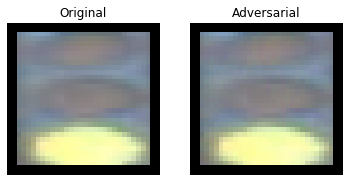

[1, 0, 0]
87


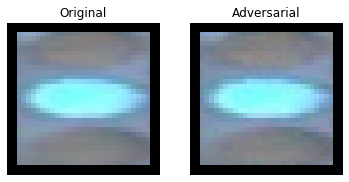

[0, 1, 0]
88


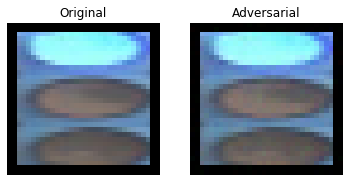

[0, 0, 1]
89


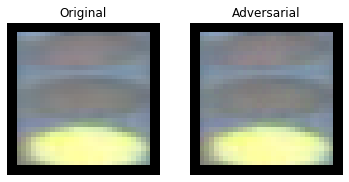

[1, 0, 0]
90


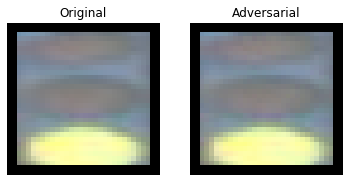

[1, 0, 0]
91


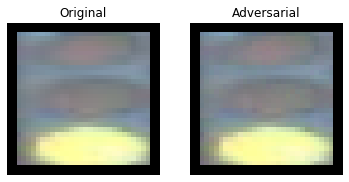

[1, 0, 0]
92


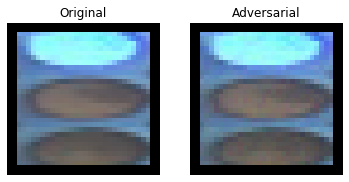

[0, 0, 1]
93


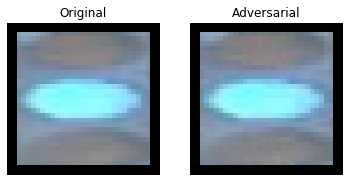

[0, 1, 0]
94


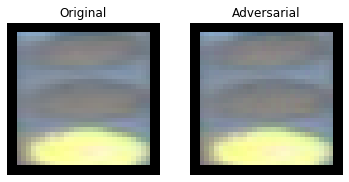

[1, 0, 0]
95


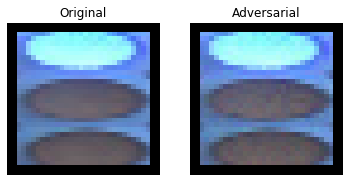

[0, 0, 1]
96


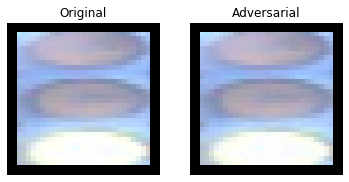

[1, 0, 0]
97


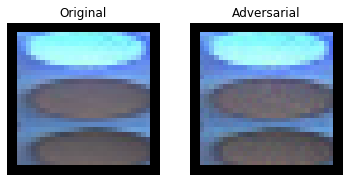

[0, 0, 1]
98


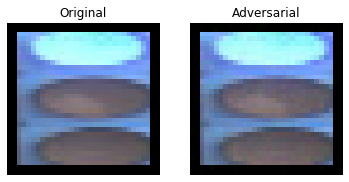

[0, 0, 1]
99


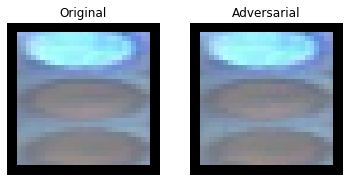

[0, 0, 1]
100


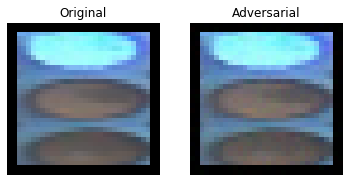

[0, 0, 1]
101


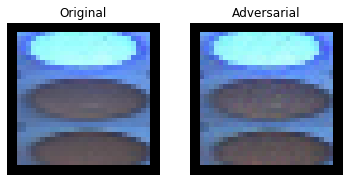

[0, 0, 1]
102


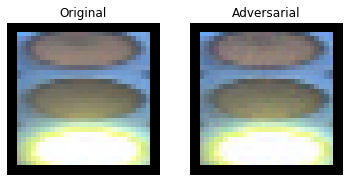

[1, 0, 0]
103


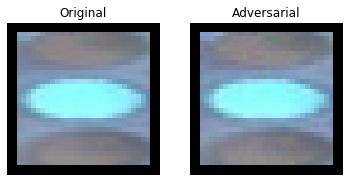

[0, 1, 0]
104


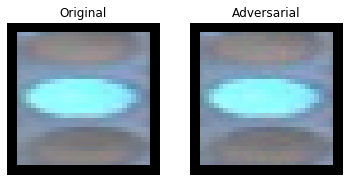

[0, 1, 0]
105


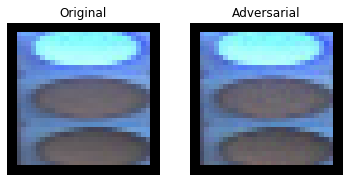

[0, 0, 1]
106


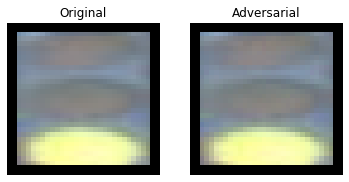

[1, 0, 0]
107


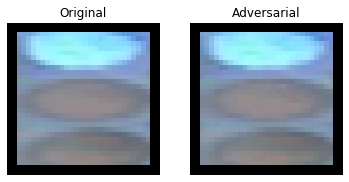

[0, 0, 1]
108


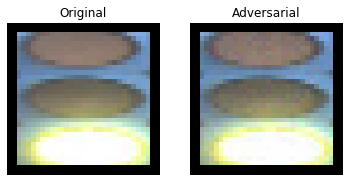

[1, 0, 0]
109


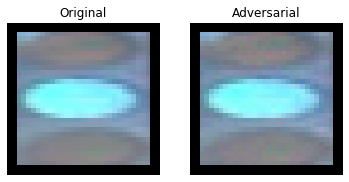

[0, 1, 0]
110


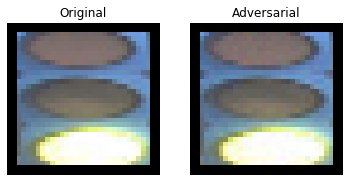

[1, 0, 0]
111


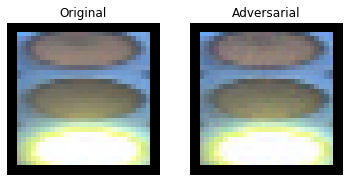

[1, 0, 0]
112


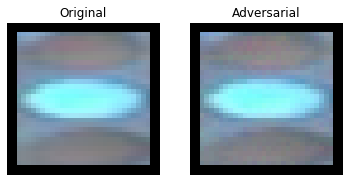

[0, 1, 0]
113


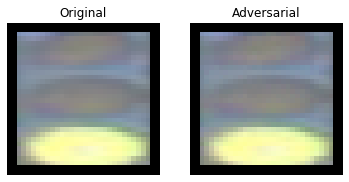

[1, 0, 0]
114


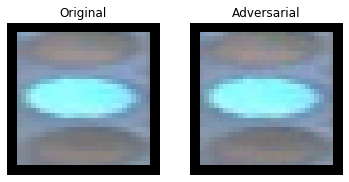

[0, 1, 0]
115


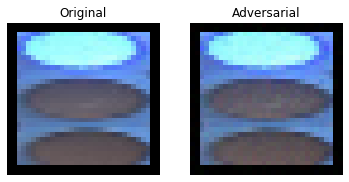

[0, 0, 1]
116


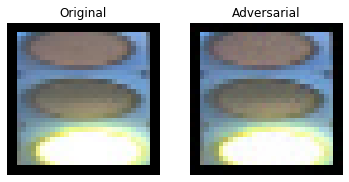

[1, 0, 0]
117


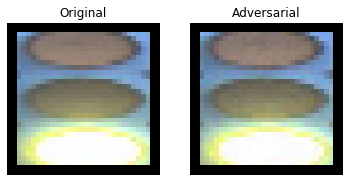

[1, 0, 0]
118


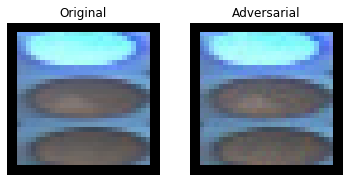

[0, 0, 1]
119


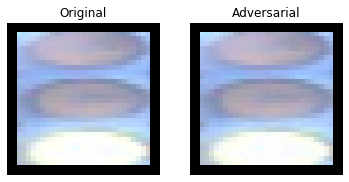

[1, 0, 0]
120


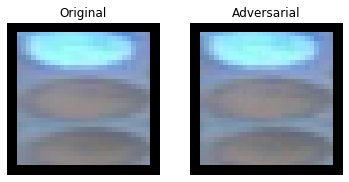

[0, 0, 1]
121


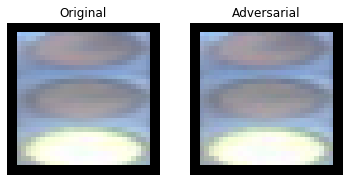

[1, 0, 0]
122


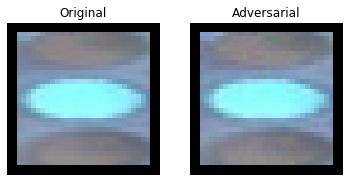

[0, 1, 0]
123


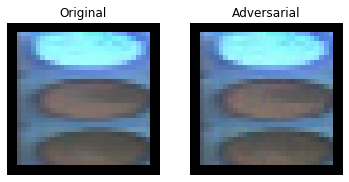

[0, 0, 1]
124


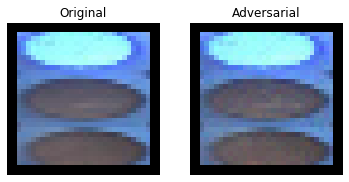

[0, 0, 1]
125


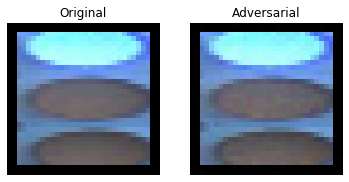

[0, 0, 1]
126


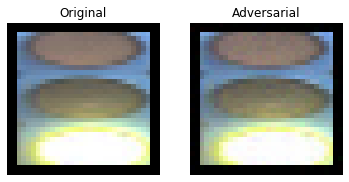

[1, 0, 0]
127


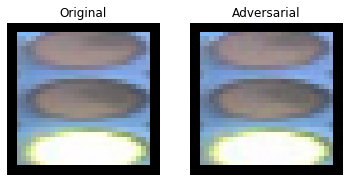

[1, 0, 0]
128


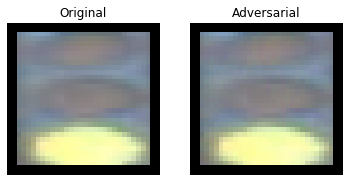

[1, 0, 0]
129


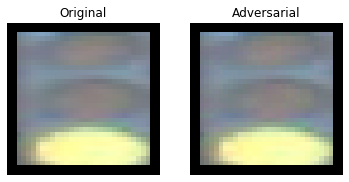

[1, 0, 0]
130


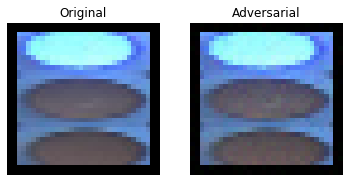

[0, 0, 1]
131


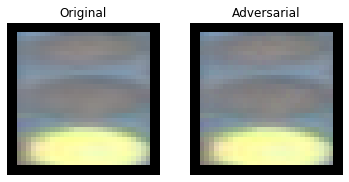

[1, 0, 0]
132


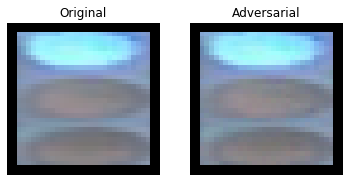

[0, 0, 1]
133


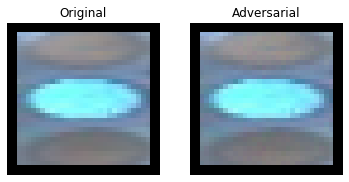

[0, 1, 0]
134


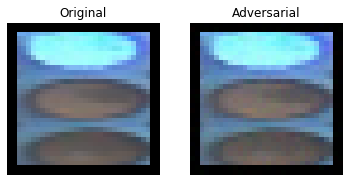

[0, 0, 1]
135


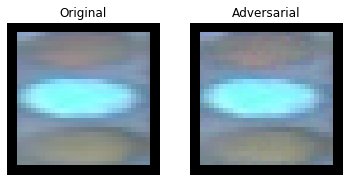

[0, 1, 0]
136


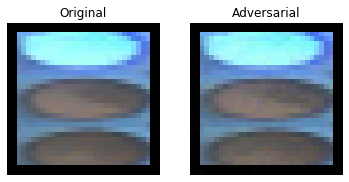

[0, 0, 1]
137


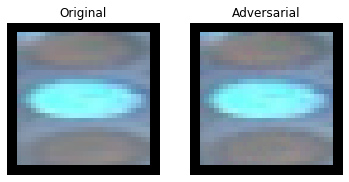

[0, 1, 0]
138


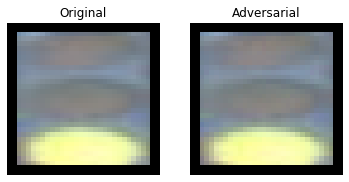

[1, 0, 0]
139


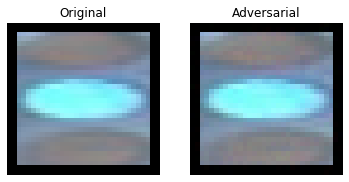

[0, 1, 0]
140


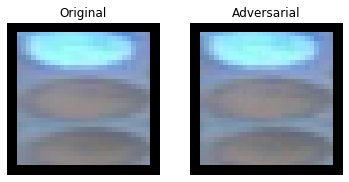

[0, 0, 1]
141


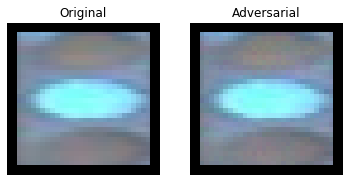

[0, 1, 0]
142


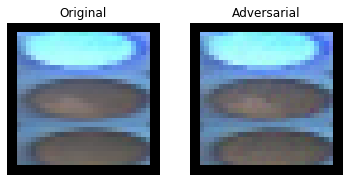

[0, 0, 1]
143


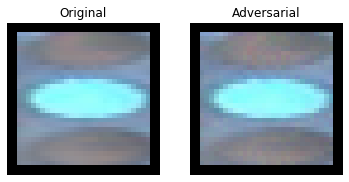

[0, 1, 0]
144


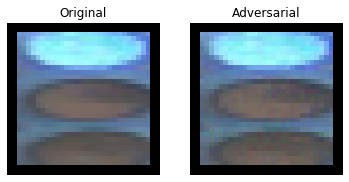

[0, 0, 1]
145


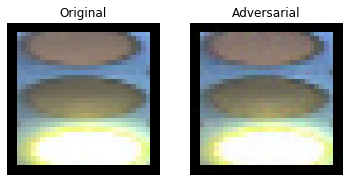

[1, 0, 0]
146


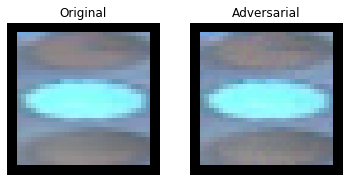

[0, 1, 0]
147


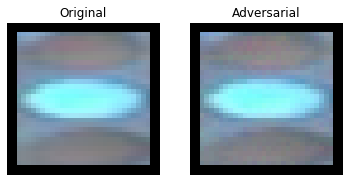

[0, 1, 0]
148


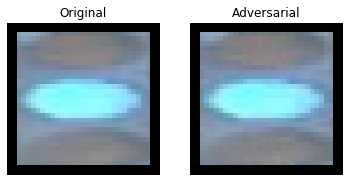

[0, 1, 0]
149


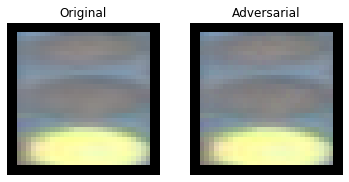

[1, 0, 0]
150


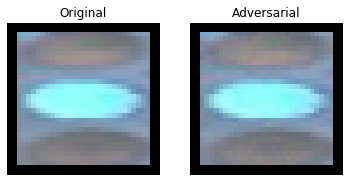

[0, 1, 0]
151


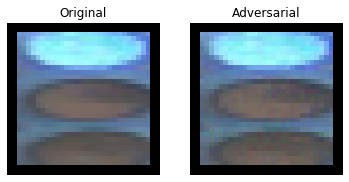

[0, 0, 1]
152


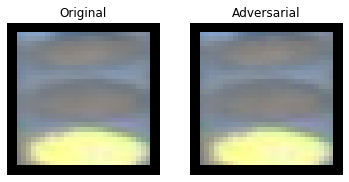

[1, 0, 0]
153


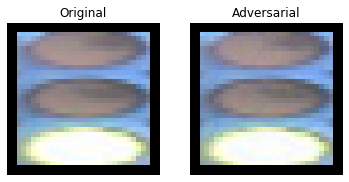

[1, 0, 0]
154


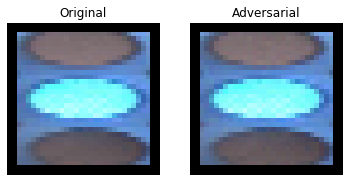

[0, 1, 0]
155


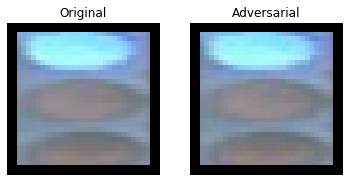

[0, 0, 1]
156


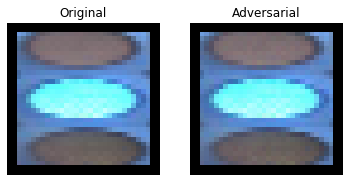

[0, 1, 0]
157


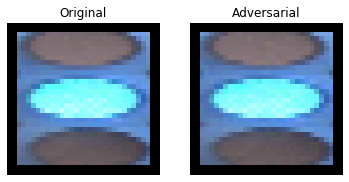

[0, 1, 0]
158


In [0]:
k = 0
count1 = 0
adversarial_images = []
adversarial_labels = []
while k < len(adversarial2):
  if np.isnan(adversarial2[k][0][0][0]) == False:
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(X_test[k])  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial2[k])  # ::-1 to convert BGR to RGB
    plt.axis('off')


    plt.show()
    adversarial_images.append(adversarial2[k])
    adversarial_labels.append(Y_test[k])
    print(Y_test[k])
    count1 += 1
    print(count1)
  k += 1

In [0]:
robust_model.evaluate(test_array_for_model(X_test), np.array(Y_test))

158/158 [==============================] - 0s 844us/step


[1.0925861793228342, 1.0]

In [0]:
import foolbox
from foolbox.attacks import SpatialAttack
from foolbox.criteria import TargetClassProbability
test_labels = []
count = 0
while count < len(Y_train):
  test_labels.append(np.argmax(Y_train[count]))
  count += 1
fmodel = foolbox.models.KerasModel(robust_model, bounds=(0, 1), preprocessing=(0,1), predicts = 'logits')
attack = foolbox.attacks.SpatialAttack(fmodel)
adversarial2 = attack(test_array_for_model(X_train), np.array(test_labels), x_shift_limits = (-3,3), y_shift_limits = (-3,3))

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:95: UserWarning: SpatialAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


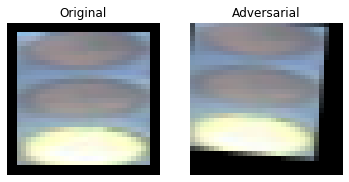

[1, 0, 0]
1


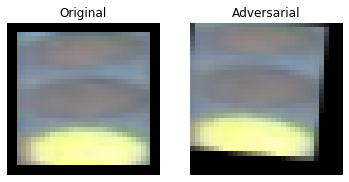

[1, 0, 0]
2


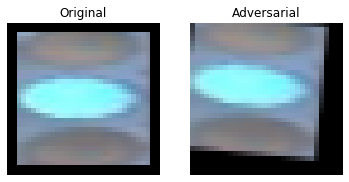

[0, 1, 0]
3


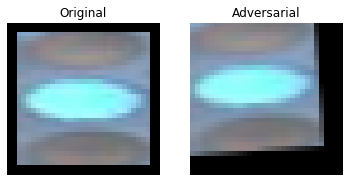

[0, 1, 0]
4


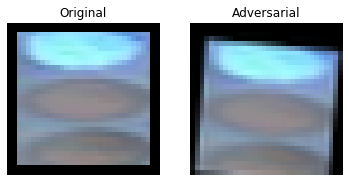

[0, 0, 1]
5


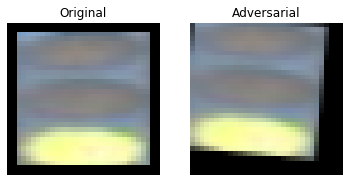

[1, 0, 0]
6


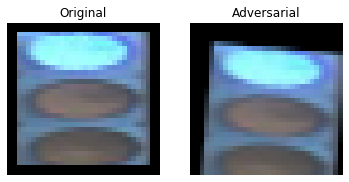

[0, 0, 1]
7


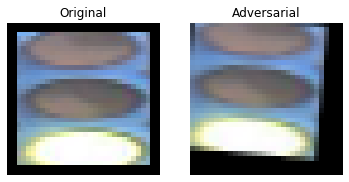

[1, 0, 0]
8


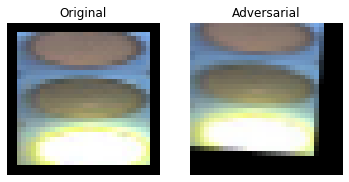

[1, 0, 0]
9


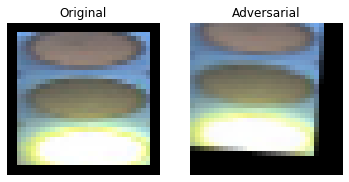

[1, 0, 0]
10


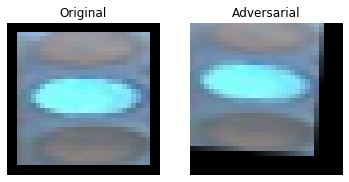

[0, 1, 0]
11


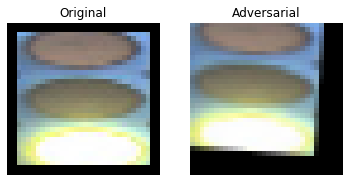

[1, 0, 0]
12


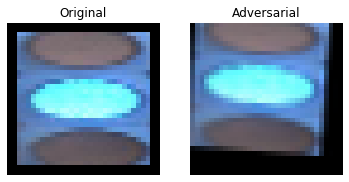

[0, 1, 0]
13


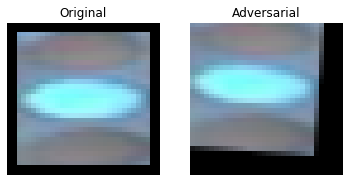

[0, 1, 0]
14


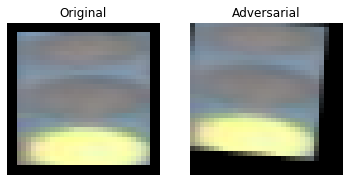

[1, 0, 0]
15


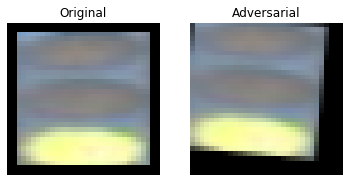

[1, 0, 0]
16


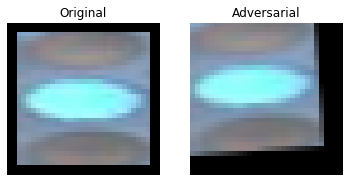

[0, 1, 0]
17


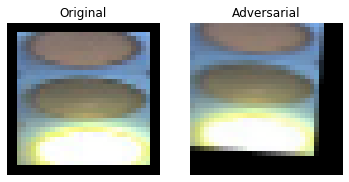

[1, 0, 0]
18


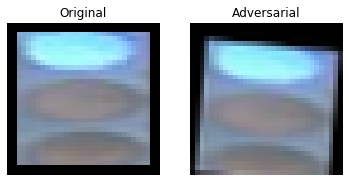

[0, 0, 1]
19


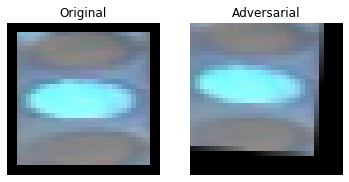

[0, 1, 0]
20


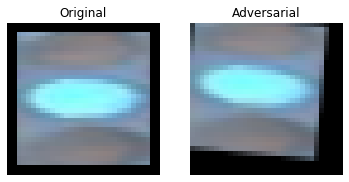

[0, 1, 0]
21


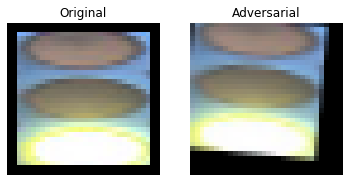

[1, 0, 0]
22


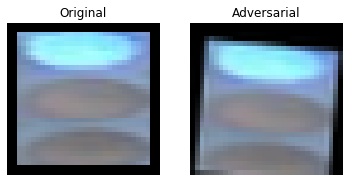

[0, 0, 1]
23


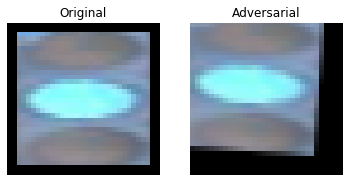

[0, 1, 0]
24


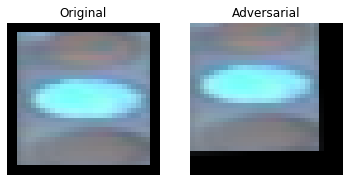

[0, 1, 0]
25


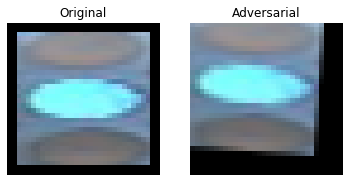

[0, 1, 0]
26


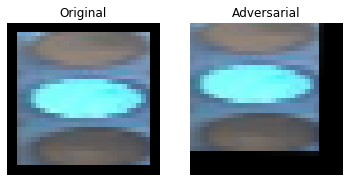

[0, 1, 0]
27


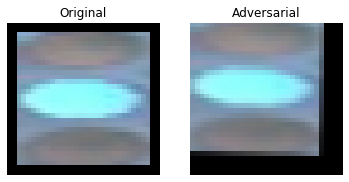

[0, 1, 0]
28


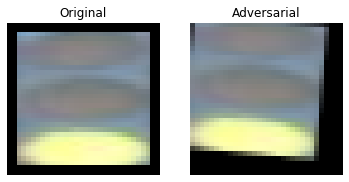

[1, 0, 0]
29


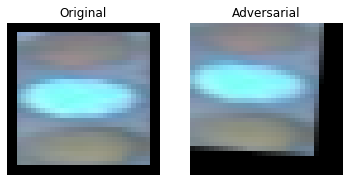

[0, 1, 0]
30


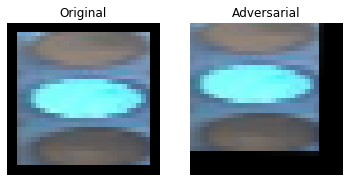

[0, 1, 0]
31


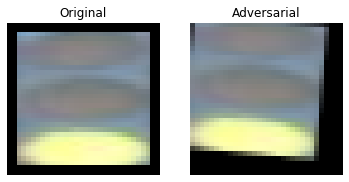

[1, 0, 0]
32


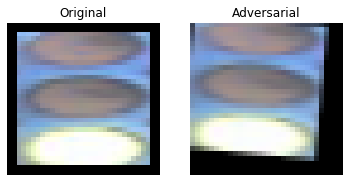

[1, 0, 0]
33


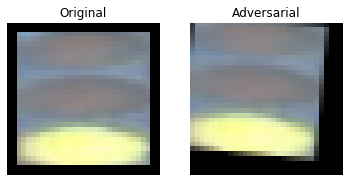

[1, 0, 0]
34


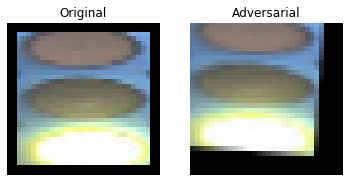

[1, 0, 0]
35


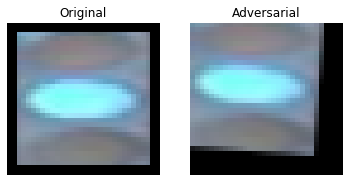

[0, 1, 0]
36


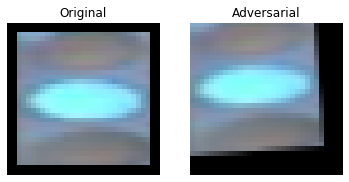

[0, 1, 0]
37


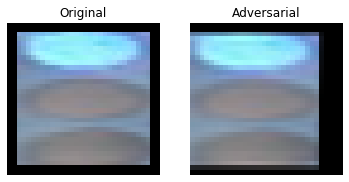

[0, 0, 1]
38


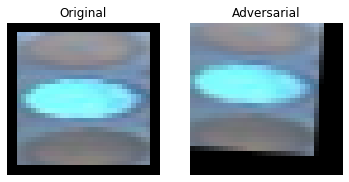

[0, 1, 0]
39


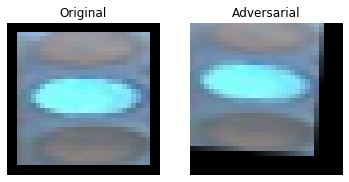

[0, 1, 0]
40


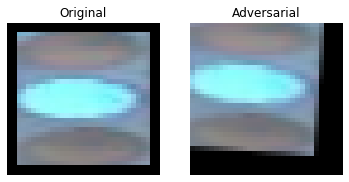

[0, 1, 0]
41


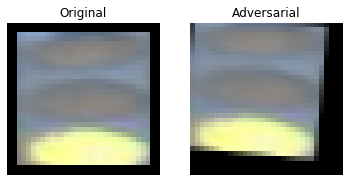

[1, 0, 0]
42


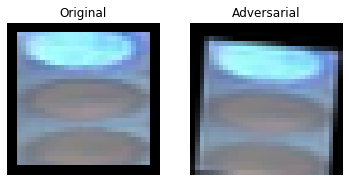

[0, 0, 1]
43


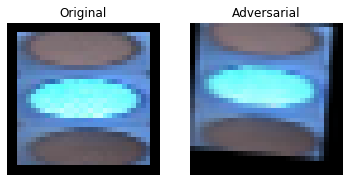

[0, 1, 0]
44


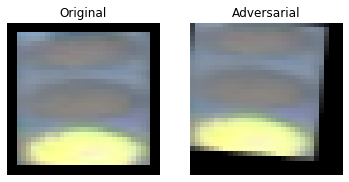

[1, 0, 0]
45


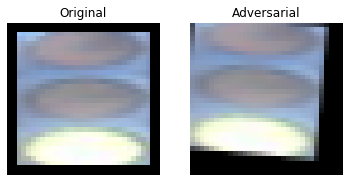

[1, 0, 0]
46


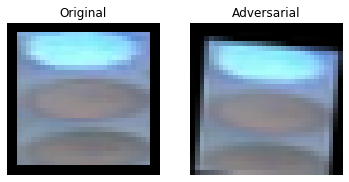

[0, 0, 1]
47


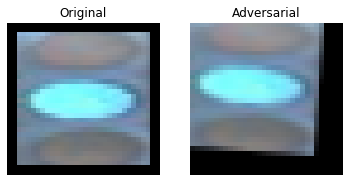

[0, 1, 0]
48


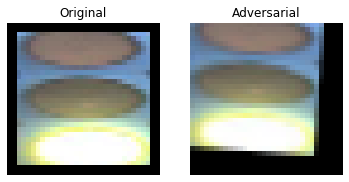

[1, 0, 0]
49


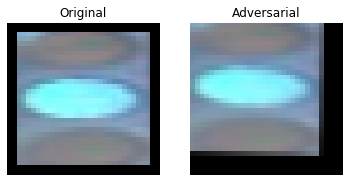

[0, 1, 0]
50


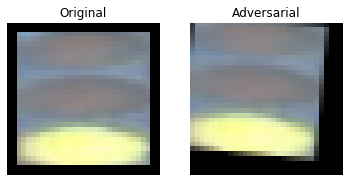

[1, 0, 0]
51


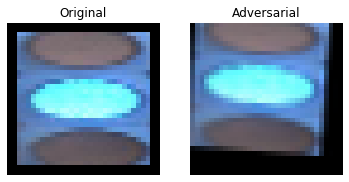

[0, 1, 0]
52


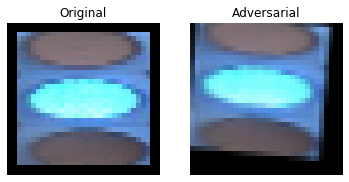

[0, 1, 0]
53


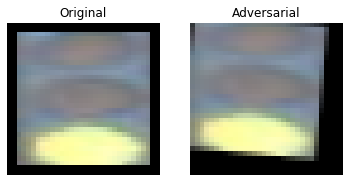

[1, 0, 0]
54


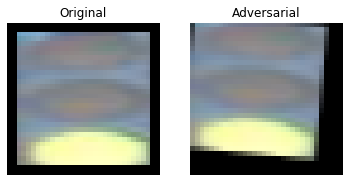

[1, 0, 0]
55


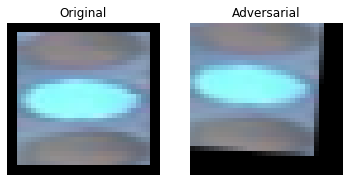

[0, 1, 0]
56


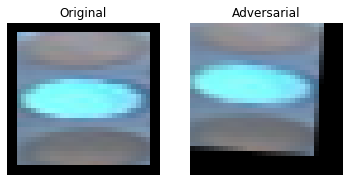

[0, 1, 0]
57


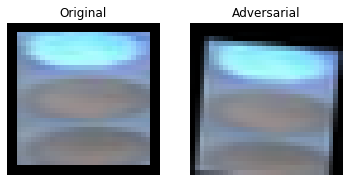

[0, 0, 1]
58


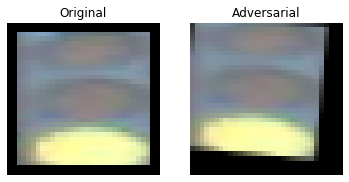

[1, 0, 0]
59


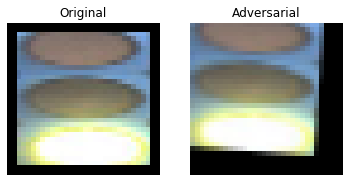

[1, 0, 0]
60


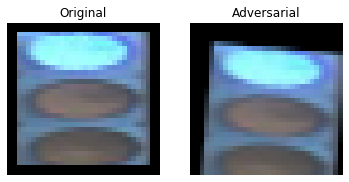

[0, 0, 1]
61


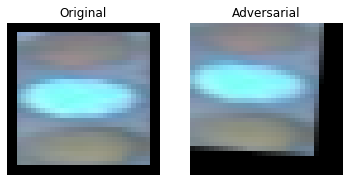

[0, 1, 0]
62


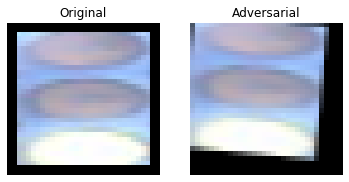

[1, 0, 0]
63


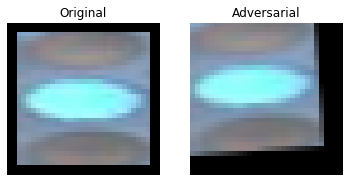

[0, 1, 0]
64


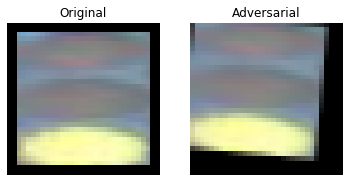

[1, 0, 0]
65


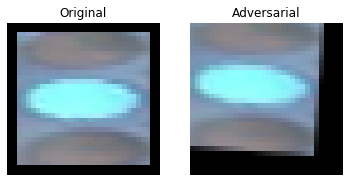

[0, 1, 0]
66


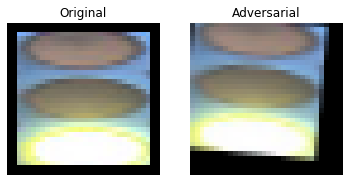

[1, 0, 0]
67


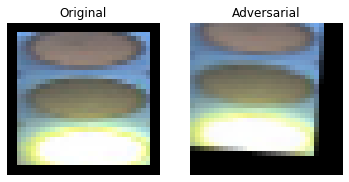

[1, 0, 0]
68


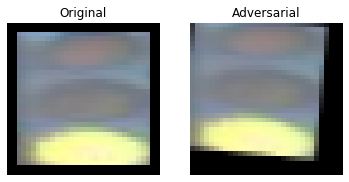

[1, 0, 0]
69


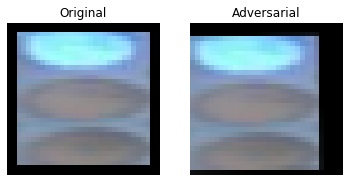

[0, 0, 1]
70


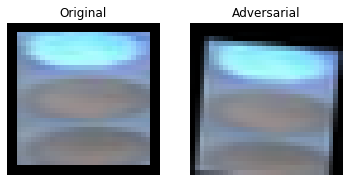

[0, 0, 1]
71


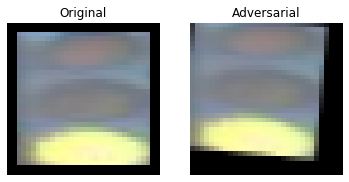

[1, 0, 0]
72


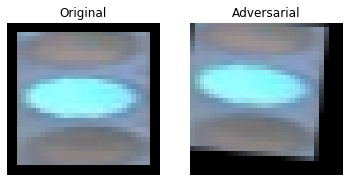

[0, 1, 0]
73


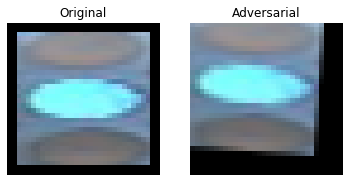

[0, 1, 0]
74


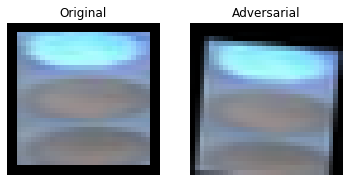

[0, 0, 1]
75


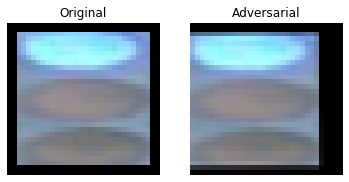

[0, 0, 1]
76


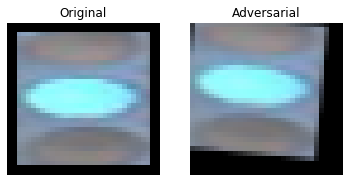

[0, 1, 0]
77


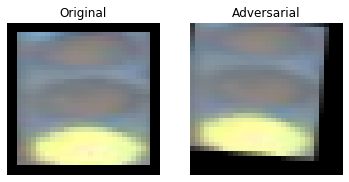

[1, 0, 0]
78


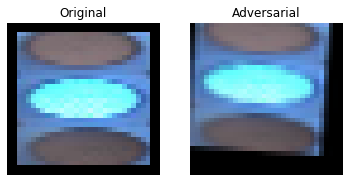

[0, 1, 0]
79


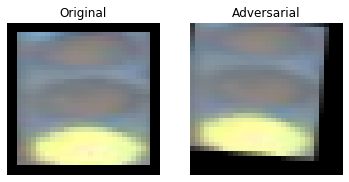

[1, 0, 0]
80


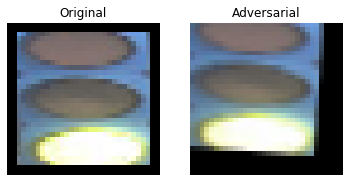

[1, 0, 0]
81


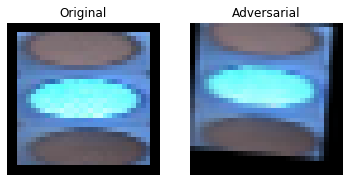

[0, 1, 0]
82


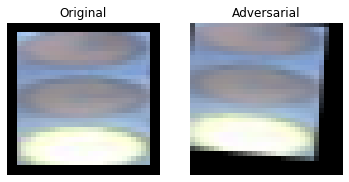

[1, 0, 0]
83


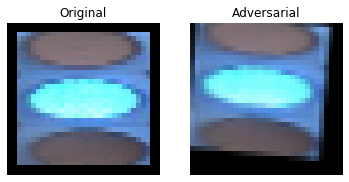

[0, 1, 0]
84


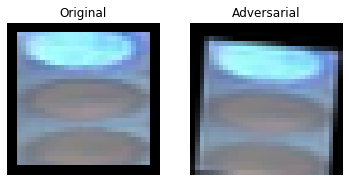

[0, 0, 1]
85


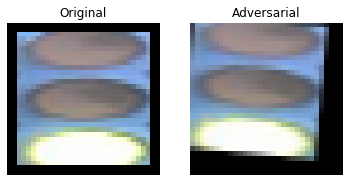

[1, 0, 0]
86


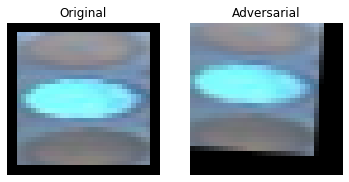

[0, 1, 0]
87


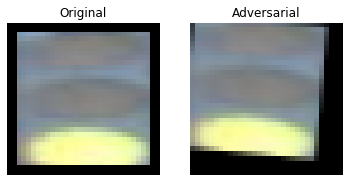

[1, 0, 0]
88


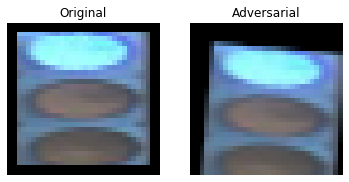

[0, 0, 1]
89


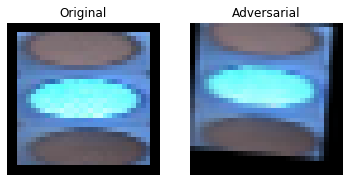

[0, 1, 0]
90


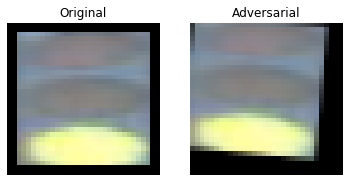

[1, 0, 0]
91


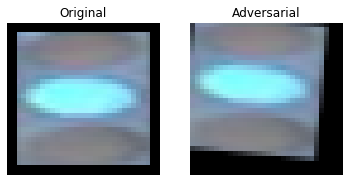

[0, 1, 0]
92


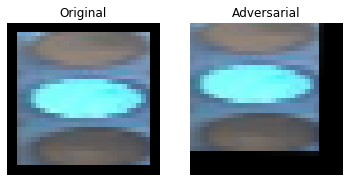

[0, 1, 0]
93


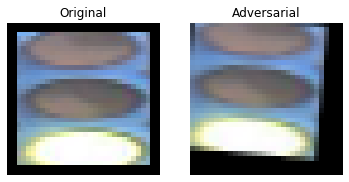

[1, 0, 0]
94


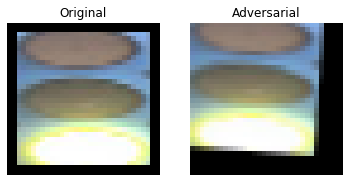

[1, 0, 0]
95


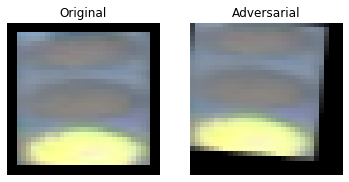

[1, 0, 0]
96


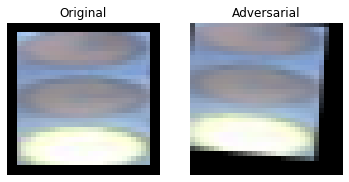

[1, 0, 0]
97


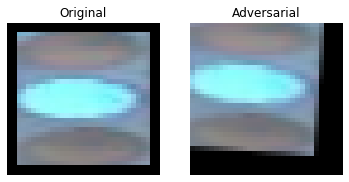

[0, 1, 0]
98


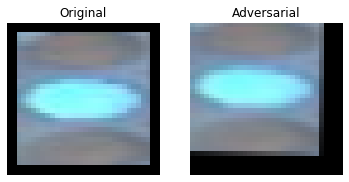

[0, 1, 0]
99


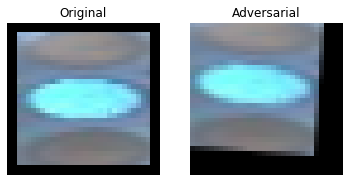

[0, 1, 0]
100


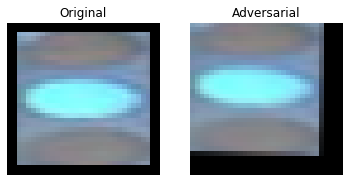

[0, 1, 0]
101


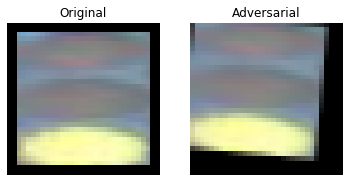

[1, 0, 0]
102


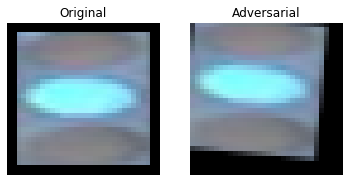

[0, 1, 0]
103


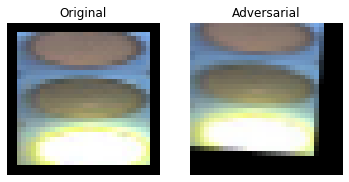

[1, 0, 0]
104


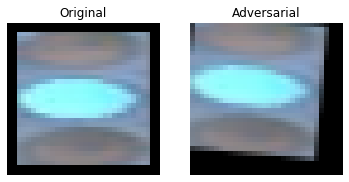

[0, 1, 0]
105


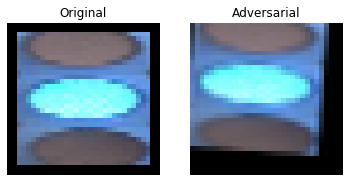

[0, 1, 0]
106


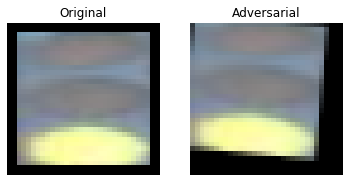

[1, 0, 0]
107


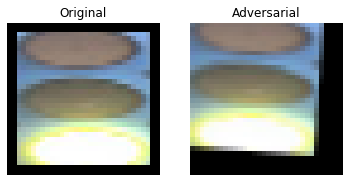

[1, 0, 0]
108


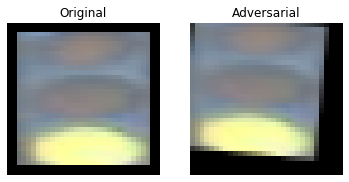

[1, 0, 0]
109


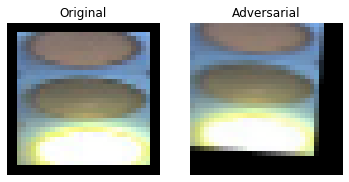

[1, 0, 0]
110


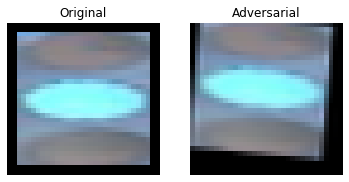

[0, 1, 0]
111


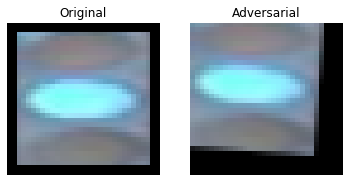

[0, 1, 0]
112


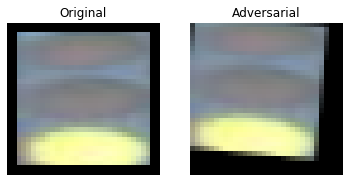

[1, 0, 0]
113


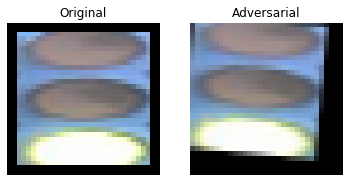

[1, 0, 0]
114


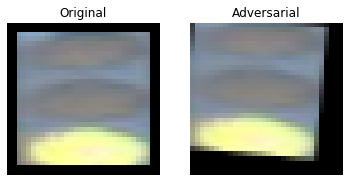

[1, 0, 0]
115


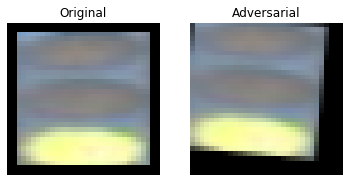

[1, 0, 0]
116


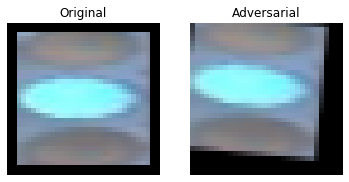

[0, 1, 0]
117


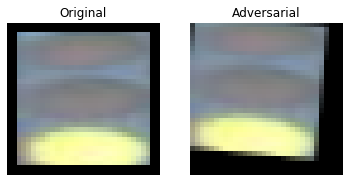

[1, 0, 0]
118


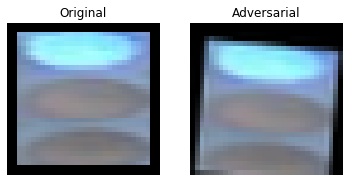

[0, 0, 1]
119


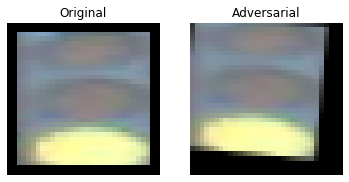

[1, 0, 0]
120


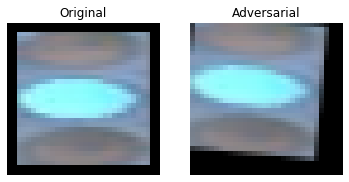

[0, 1, 0]
121


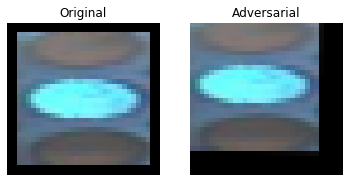

[0, 1, 0]
122


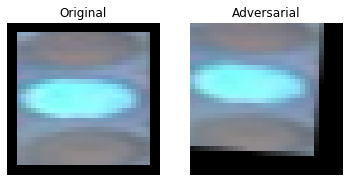

[0, 1, 0]
123


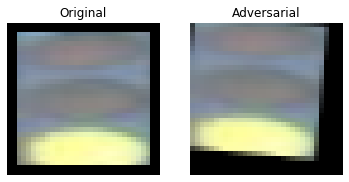

[1, 0, 0]
124


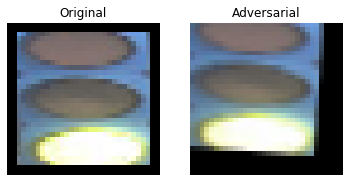

[1, 0, 0]
125


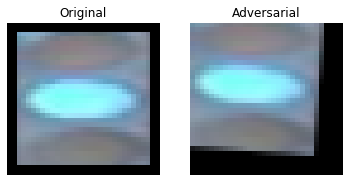

[0, 1, 0]
126


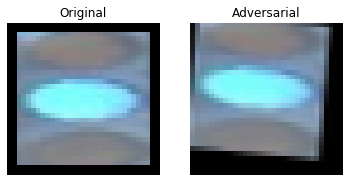

[0, 1, 0]
127


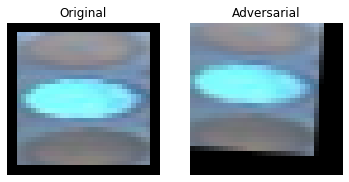

[0, 1, 0]
128


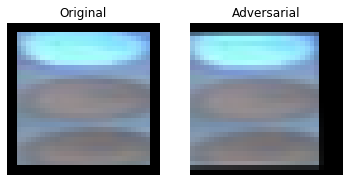

[0, 0, 1]
129


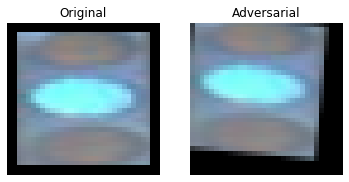

[0, 1, 0]
130


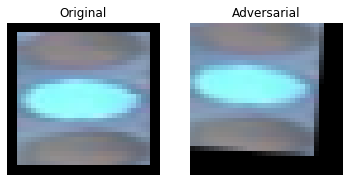

[0, 1, 0]
131


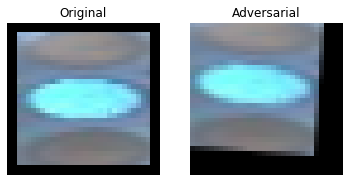

[0, 1, 0]
132


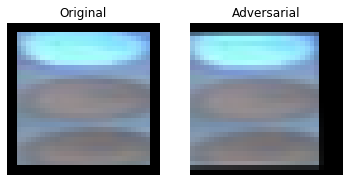

[0, 0, 1]
133


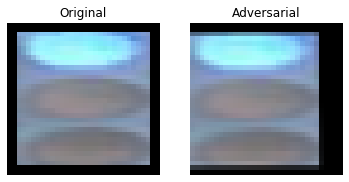

[0, 0, 1]
134


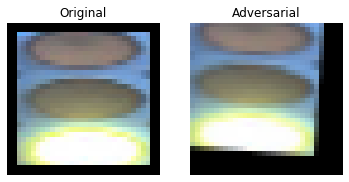

[1, 0, 0]
135


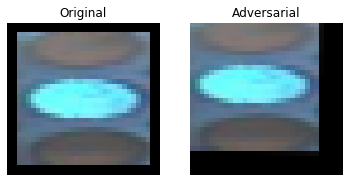

[0, 1, 0]
136


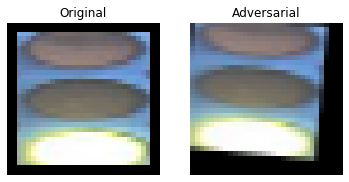

[1, 0, 0]
137


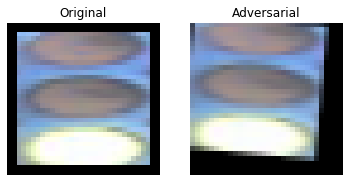

[1, 0, 0]
138


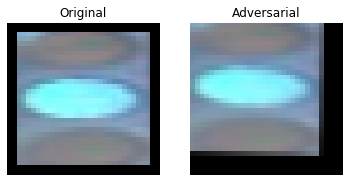

[0, 1, 0]
139


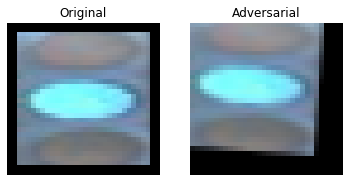

[0, 1, 0]
140


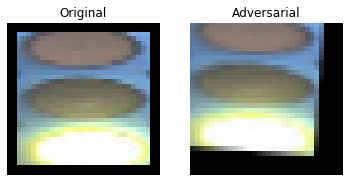

[1, 0, 0]
141


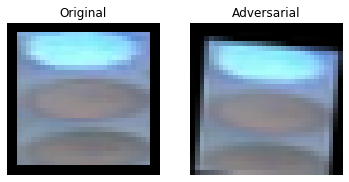

[0, 0, 1]
142


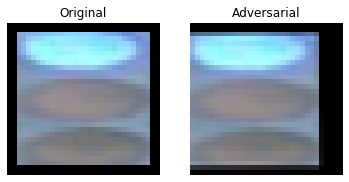

[0, 0, 1]
143


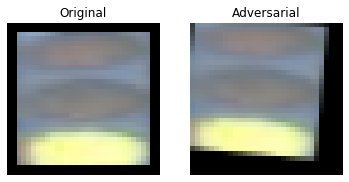

[1, 0, 0]
144


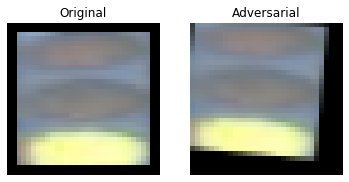

[1, 0, 0]
145


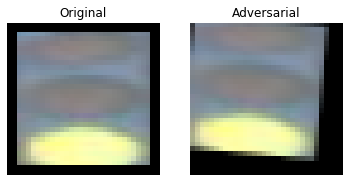

[1, 0, 0]
146


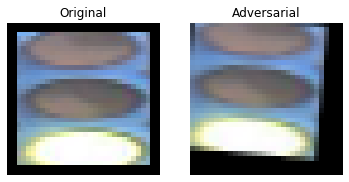

[1, 0, 0]
147


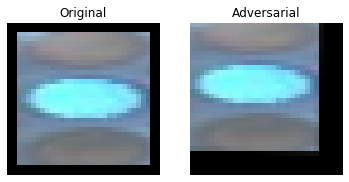

[0, 1, 0]
148


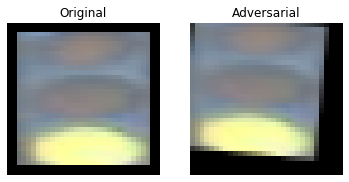

[1, 0, 0]
149


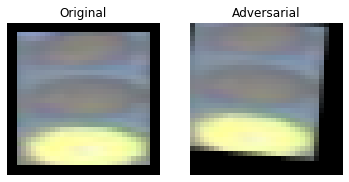

[1, 0, 0]
150


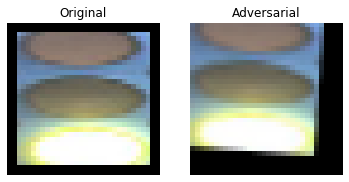

[1, 0, 0]
151


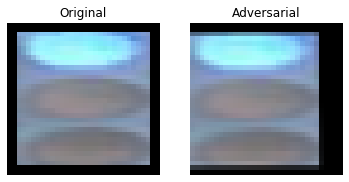

[0, 0, 1]
152


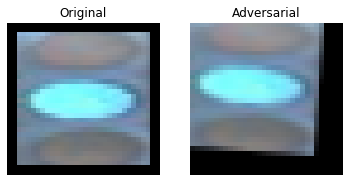

[0, 1, 0]
153


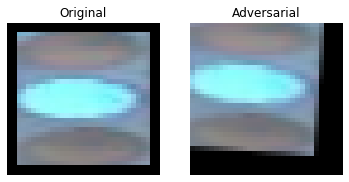

[0, 1, 0]
154


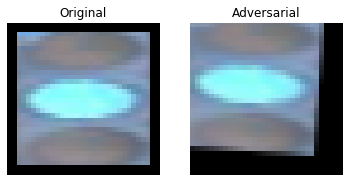

[0, 1, 0]
155


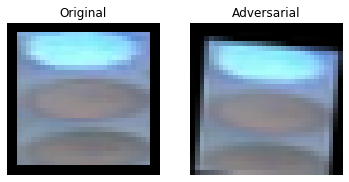

[0, 0, 1]
156


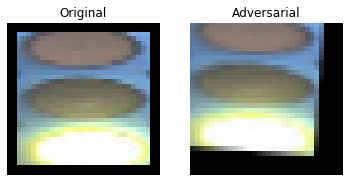

[1, 0, 0]
157


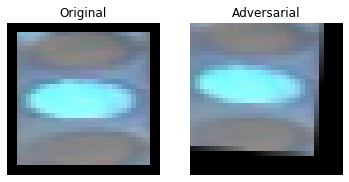

[0, 1, 0]
158


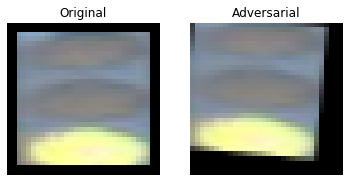

[1, 0, 0]
159


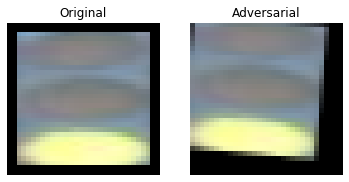

[1, 0, 0]
160


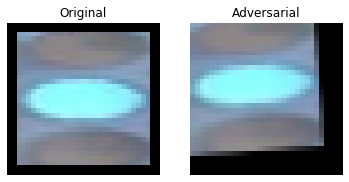

[0, 1, 0]
161


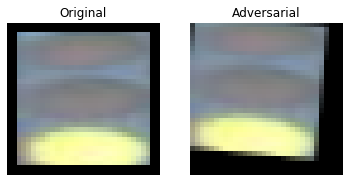

[1, 0, 0]
162


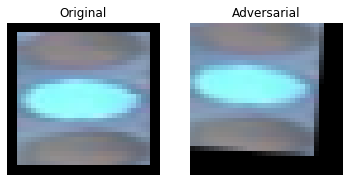

[0, 1, 0]
163


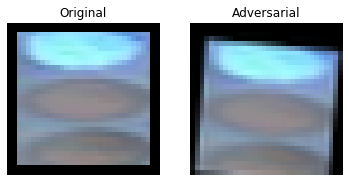

[0, 0, 1]
164


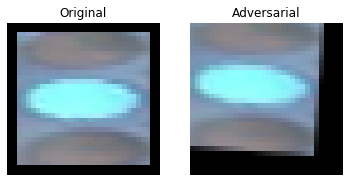

[0, 1, 0]
165


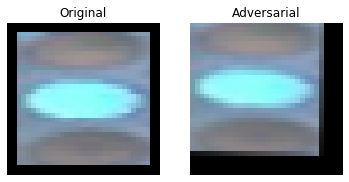

[0, 1, 0]
166


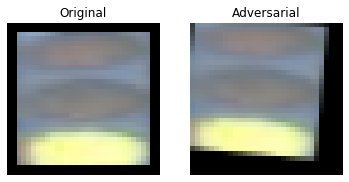

[1, 0, 0]
167


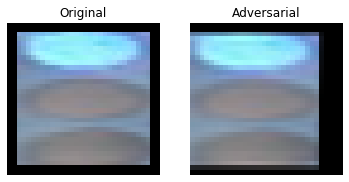

[0, 0, 1]
168


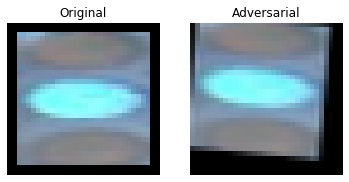

[0, 1, 0]
169


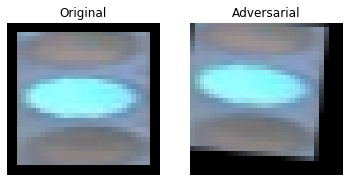

[0, 1, 0]
170


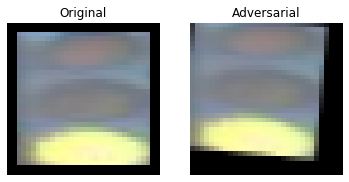

[1, 0, 0]
171


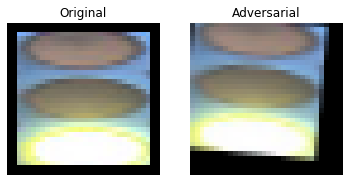

[1, 0, 0]
172


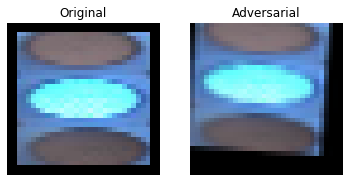

[0, 1, 0]
173


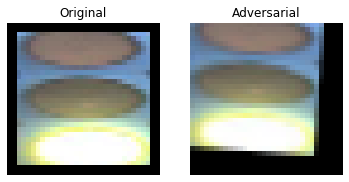

[1, 0, 0]
174


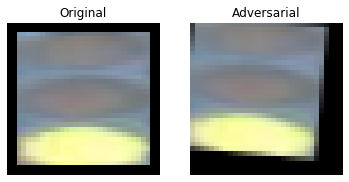

[1, 0, 0]
175


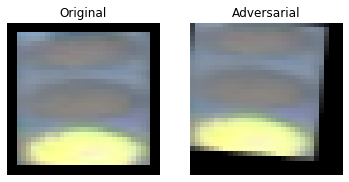

[1, 0, 0]
176


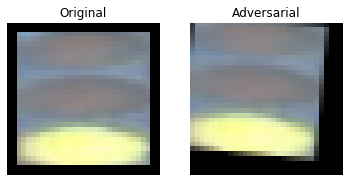

[1, 0, 0]
177


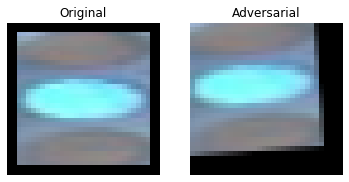

[0, 1, 0]
178


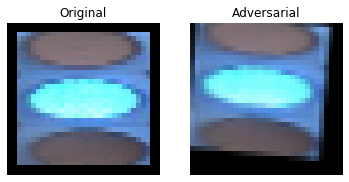

[0, 1, 0]
179


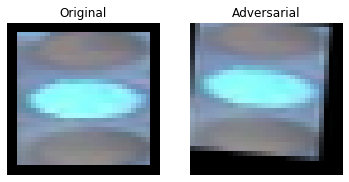

[0, 1, 0]
180


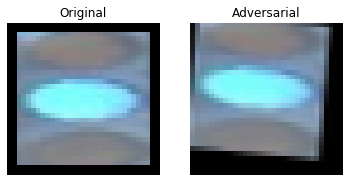

[0, 1, 0]
181


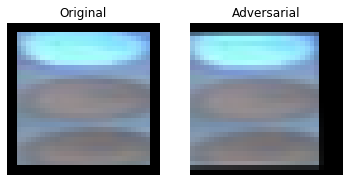

[0, 0, 1]
182


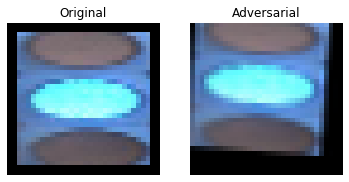

[0, 1, 0]
183


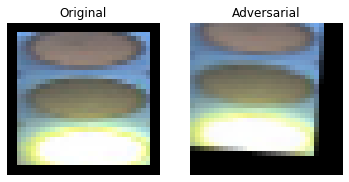

[1, 0, 0]
184


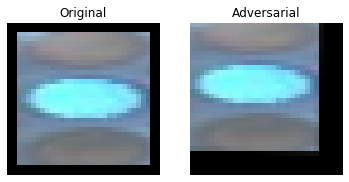

[0, 1, 0]
185


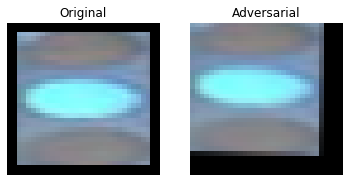

[0, 1, 0]
186


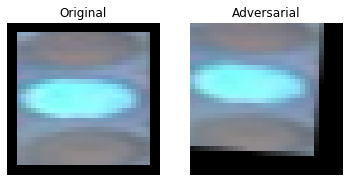

[0, 1, 0]
187


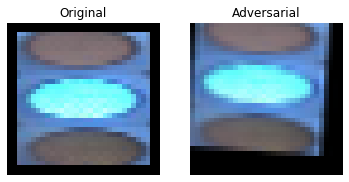

[0, 1, 0]
188


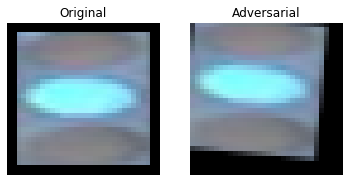

[0, 1, 0]
189


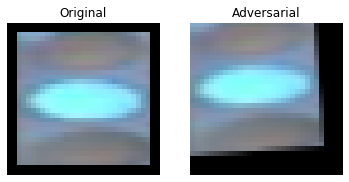

[0, 1, 0]
190


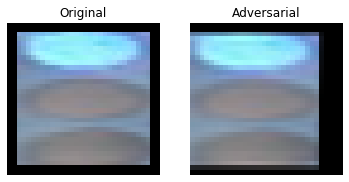

[0, 0, 1]
191


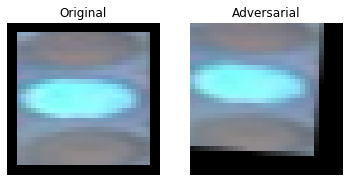

[0, 1, 0]
192


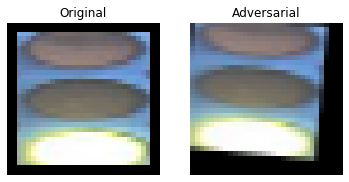

[1, 0, 0]
193


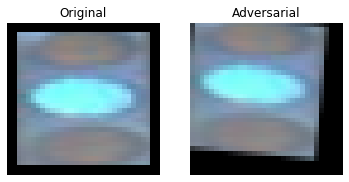

[0, 1, 0]
194


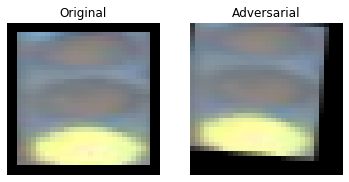

[1, 0, 0]
195


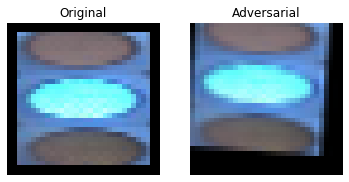

[0, 1, 0]
196


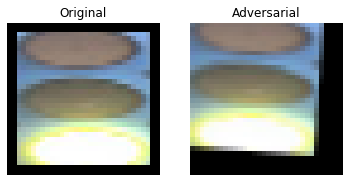

[1, 0, 0]
197


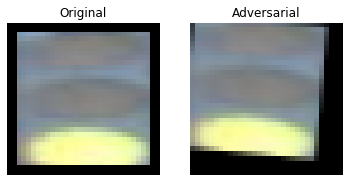

[1, 0, 0]
198


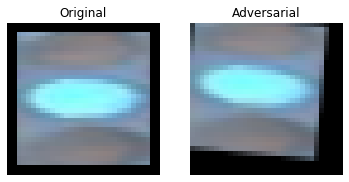

[0, 1, 0]
199


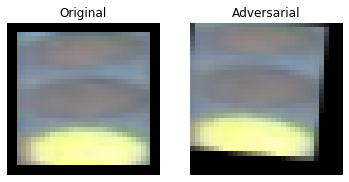

[1, 0, 0]
200


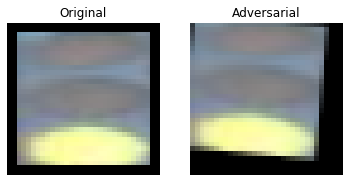

[1, 0, 0]
201


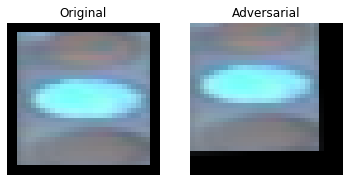

[0, 1, 0]
202


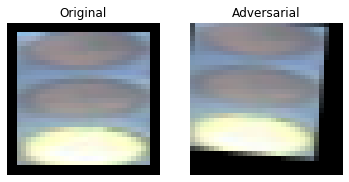

[1, 0, 0]
203


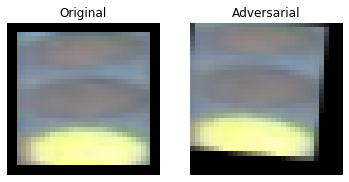

[1, 0, 0]
204


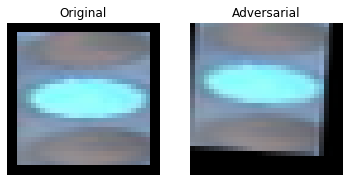

[0, 1, 0]
205


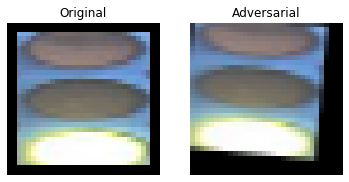

[1, 0, 0]
206


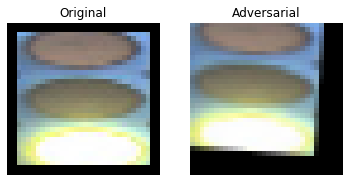

[1, 0, 0]
207


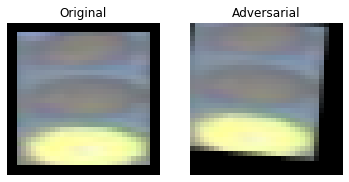

[1, 0, 0]
208


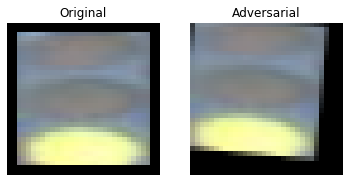

[1, 0, 0]
209


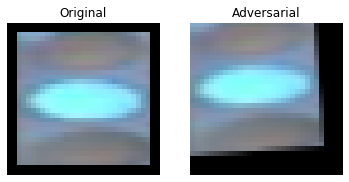

[0, 1, 0]
210


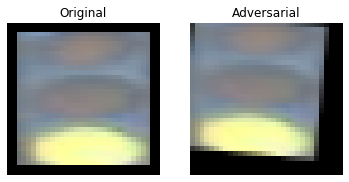

[1, 0, 0]
211


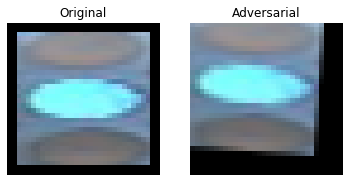

[0, 1, 0]
212


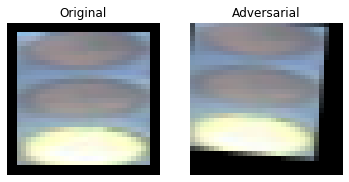

[1, 0, 0]
213


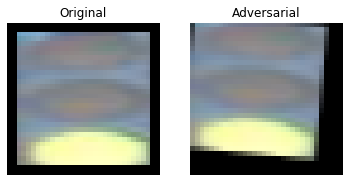

[1, 0, 0]
214


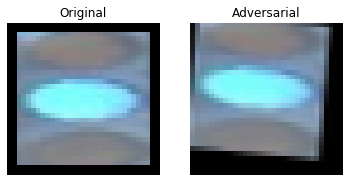

[0, 1, 0]
215


In [0]:
k = 0
count1 = 0
adversarial_images2 = []
adversarial_labels2 = []
while k < len(adversarial2):
  if np.isnan(adversarial2[k][0][0][0]) == False:
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(X_train[k])  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial2[k])  # ::-1 to convert BGR to RGB
    plt.axis('off')


    plt.show()
    adversarial_images2.append(adversarial2[k])
    adversarial_labels2.append(Y_train[k])
    print(Y_train[k])
    count1 += 1
    print(count1)
  k += 1
  

In [0]:
print(len(adversarial_images2))

215


In [0]:
import foolbox
from foolbox.attacks import CarliniWagnerL2Attack
from foolbox.criteria import TargetClassProbability
test_labels = []
count = 0
while count < len(Y_train):
  test_labels.append(np.argmax(Y_train[count]))
  count += 1

fmodel = foolbox.models.KerasModel(robust_model, bounds=(0, 1), preprocessing=(0,1), predicts = 'logits')
attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)
adversarial2 = attack(test_array_for_model(X_train), np.array(test_labels))

In [0]:
k = 0
count1 = 0
while k < len(adversarial2):
  if np.isnan(adversarial2[k][0][0][0]) == False:
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(X_train[k])  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial2[k])  # ::-1 to convert BGR to RGB
    plt.axis('off')


    plt.show()
    adversarial_images2.append(adversarial2[k])
    adversarial_labels2.append(Y_train[k])
    print(Y_train[k])
    count1 += 1
    print(count1)
  k += 1
print(len(adversarial_images2))
print(len(adversarial_labels2))
  

In [0]:
X_train_new, X_test_new, Y_train_new, Y_test_new = train_test_split(adversarial_images2, adversarial_labels2, test_size=0.33, random_state=seed)

In [0]:
print(len(X_train_new))
print(len(Y_train_new))

357
357


In [0]:
robust_distilled_model = train_distillation(test_array_for_model(X_train_new), np.array(Y_train_new), os.path.join(root_path, 'Robust_Distilled_Model.pt'), num_epochs = 3, train_temp = 100)

(357, 32, 32, 3)
Train on 249 samples, validate on 108 samples
Epoch 1/1
249/249 [==============================] - 1s 5ms/step - loss: 1.1781 - acc: 0.3775 - val_loss: 0.5798 - val_acc: 0.9167
(357, 32, 32, 3)
Train on 249 samples, validate on 108 samples
Epoch 1/3
249/249 [==============================] - 1s 5ms/step - loss: 1.0914 - acc: 0.9116 - val_loss: 1.0913 - val_acc: 0.9167
Epoch 2/3
249/249 [==============================] - 1s 3ms/step - loss: 1.0912 - acc: 0.9197 - val_loss: 1.0911 - val_acc: 0.9167
Epoch 3/3
249/249 [==============================] - 1s 3ms/step - loss: 1.0910 - acc: 0.9277 - val_loss: 1.0909 - val_acc: 0.9167
[[0.33154905 0.33588532 0.33256564]
 [0.33197424 0.33702075 0.331005  ]
 [0.3358984  0.33309144 0.33101013]
 ...
 [0.33271518 0.3367392  0.33054566]
 [0.33710608 0.33413664 0.32875735]
 [0.33661687 0.33441272 0.3289704 ]]
(357, 32, 32, 3)
Train on 249 samples, validate on 108 samples
Epoch 1/3
249/249 [==============================] - 1s 5ms/step 

In [0]:
robust_distilled_model.evaluate(test_array_for_model(X_test_new), np.array(Y_test_new))

177/177 [==============================] - 0s 801us/step


[1.0915179555698977, 0.9378531076813822]

In [0]:
import foolbox
from foolbox.attacks import SpatialAttack
from foolbox.criteria import TargetClassProbability
test_labels = []
count = 0
while count < len(Y_test_new):
  test_labels.append(np.argmax(Y_test_new[count]))
  count += 1
fmodel = foolbox.models.KerasModel(robust_distilled_model, bounds=(0, 1), preprocessing=(0,1), predicts = 'logits')
attack = foolbox.attacks.SpatialAttack(fmodel)
adversarial2 = attack(test_array_for_model(X_test_new), np.array(test_labels), x_shift_limits = (-3,3), y_shift_limits = (-3,3))

/usr/local/lib/python3.6/dist-packages/foolbox/attacks/base.py:95: UserWarning: SpatialAttack did not find an adversarial, maybe the model or the criterion is not supported by this attack.
  " attack.".format(self.name())


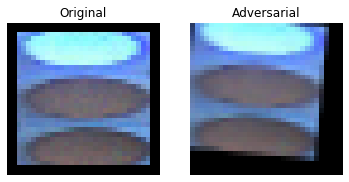

[0, 0, 1]
1


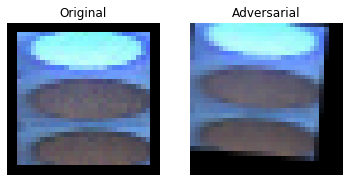

[0, 0, 1]
2


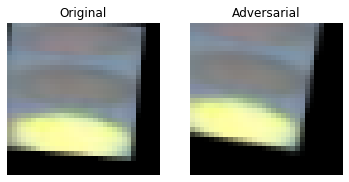

[1, 0, 0]
3


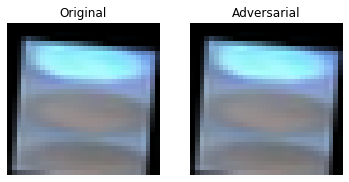

[0, 0, 1]
4


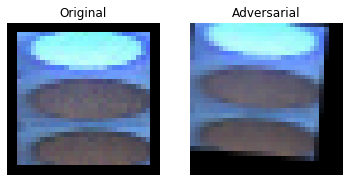

[0, 0, 1]
5


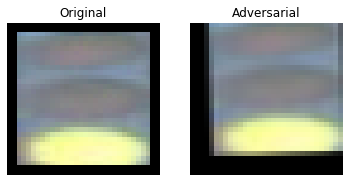

[1, 0, 0]
6


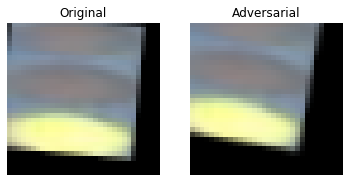

[1, 0, 0]
7


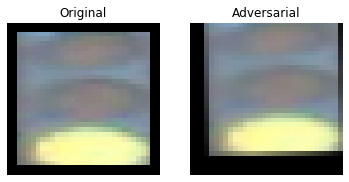

[1, 0, 0]
8


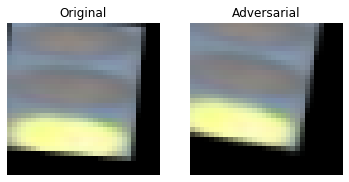

[1, 0, 0]
9


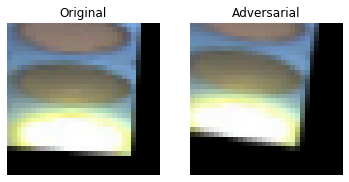

[1, 0, 0]
10


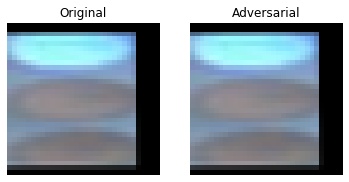

[0, 0, 1]
11


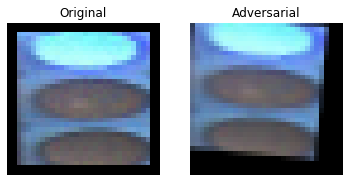

[0, 0, 1]
12


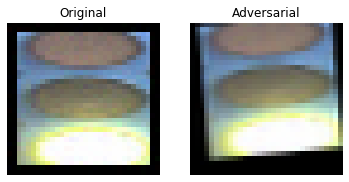

[1, 0, 0]
13


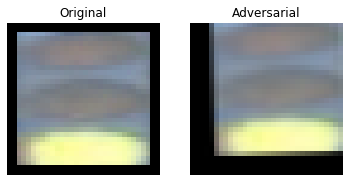

[1, 0, 0]
14


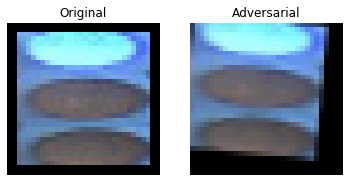

[0, 0, 1]
15


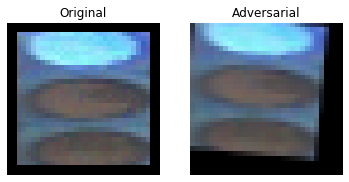

[0, 0, 1]
16


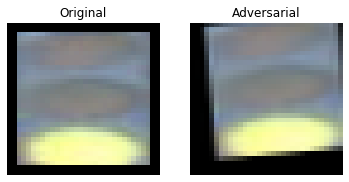

[1, 0, 0]
17


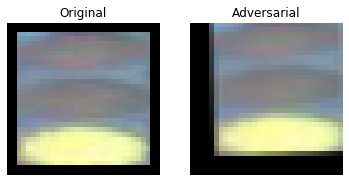

[1, 0, 0]
18


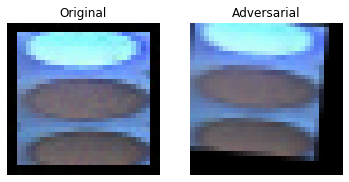

[0, 0, 1]
19


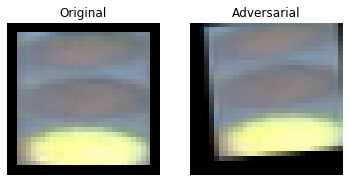

[1, 0, 0]
20


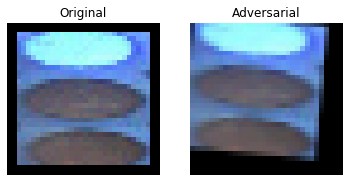

[0, 0, 1]
21


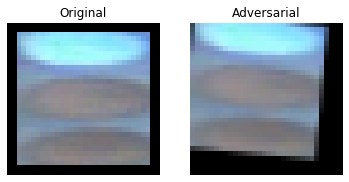

[0, 0, 1]
22


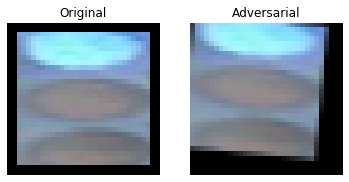

[0, 0, 1]
23


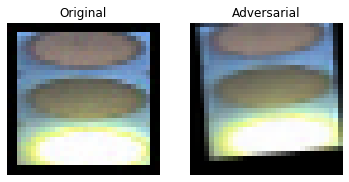

[1, 0, 0]
24


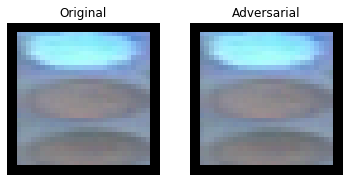

[0, 0, 1]
25


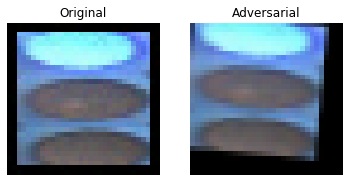

[0, 0, 1]
26


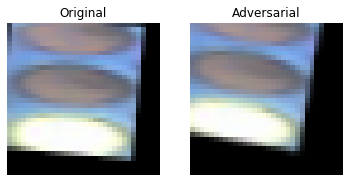

[1, 0, 0]
27


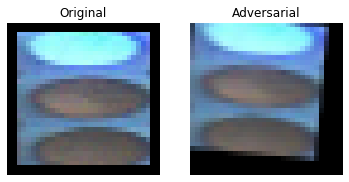

[0, 0, 1]
28


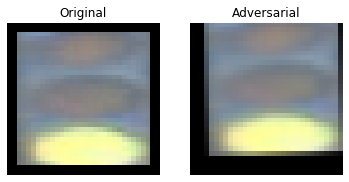

[1, 0, 0]
29


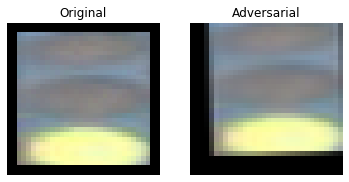

[1, 0, 0]
30


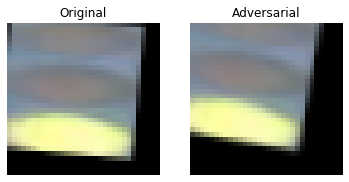

[1, 0, 0]
31


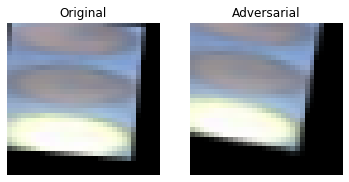

[1, 0, 0]
32


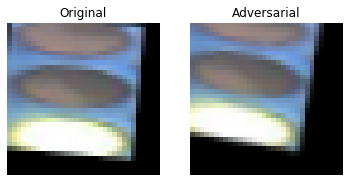

[1, 0, 0]
33


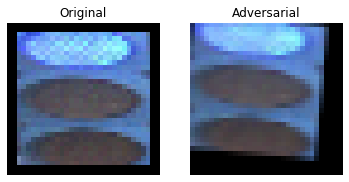

[0, 0, 1]
34


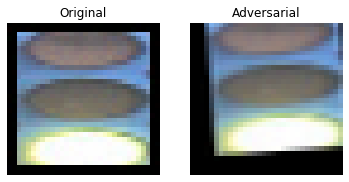

[1, 0, 0]
35


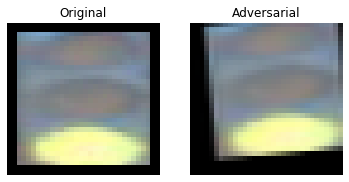

[1, 0, 0]
36


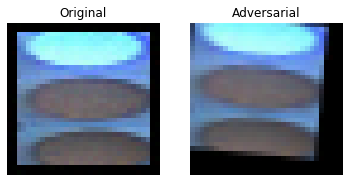

[0, 0, 1]
37


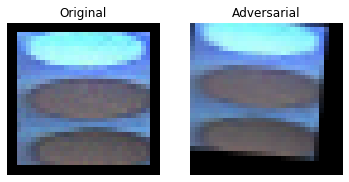

[0, 0, 1]
38


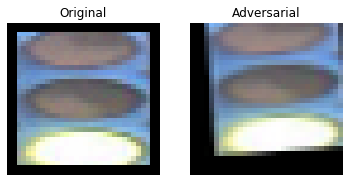

[1, 0, 0]
39


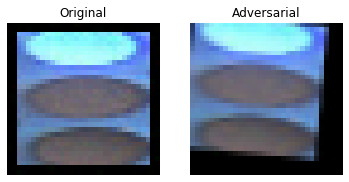

[0, 0, 1]
40


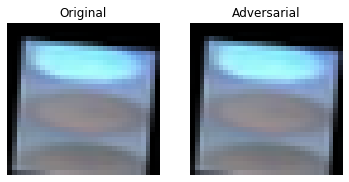

[0, 0, 1]
41


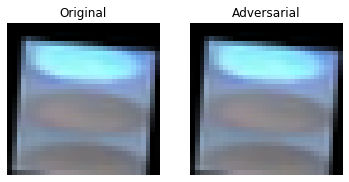

[0, 0, 1]
42


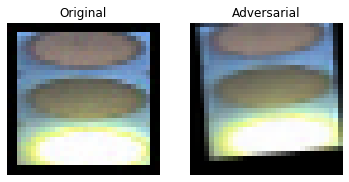

[1, 0, 0]
43


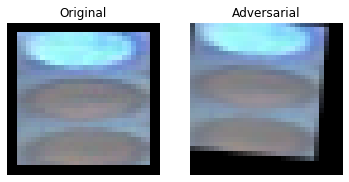

[0, 0, 1]
44


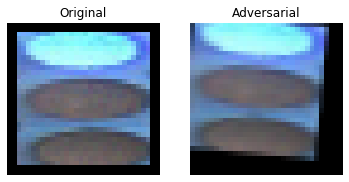

[0, 0, 1]
45


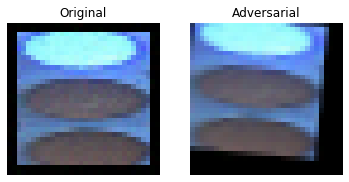

[0, 0, 1]
46


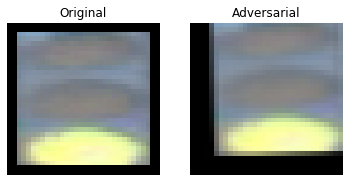

[1, 0, 0]
47


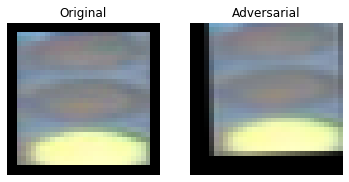

[1, 0, 0]
48


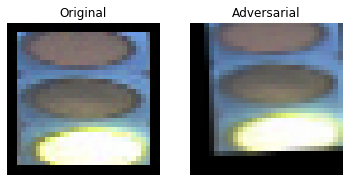

[1, 0, 0]
49


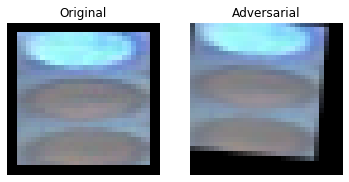

[0, 0, 1]
50


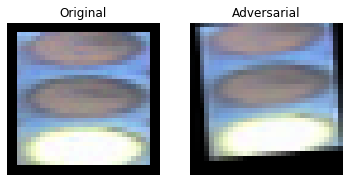

[1, 0, 0]
51


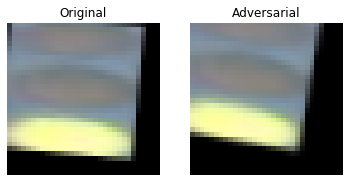

[1, 0, 0]
52


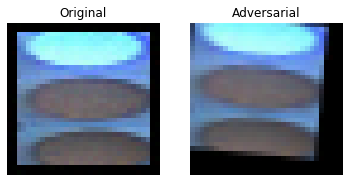

[0, 0, 1]
53


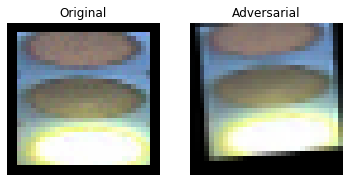

[1, 0, 0]
54


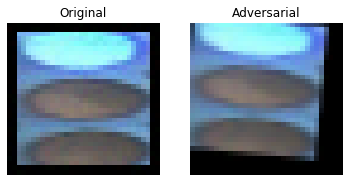

[0, 0, 1]
55


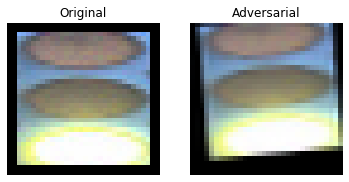

[1, 0, 0]
56


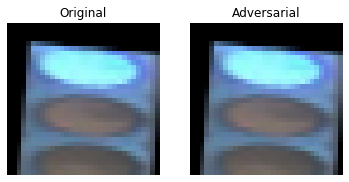

[0, 0, 1]
57


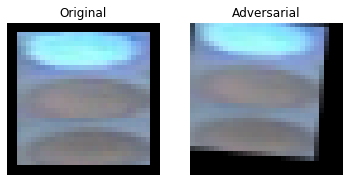

[0, 0, 1]
58


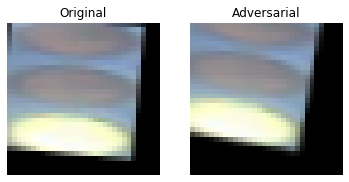

[1, 0, 0]
59


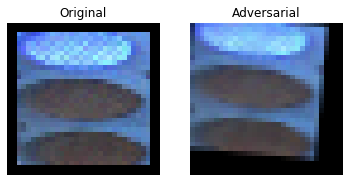

[0, 0, 1]
60


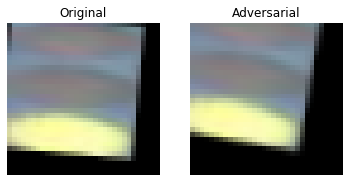

[1, 0, 0]
61


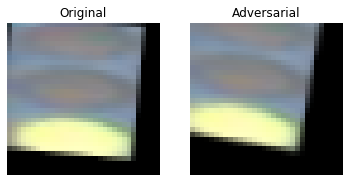

[1, 0, 0]
62


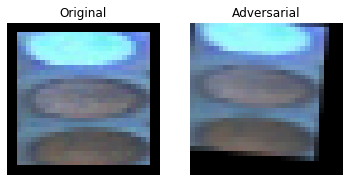

[0, 0, 1]
63


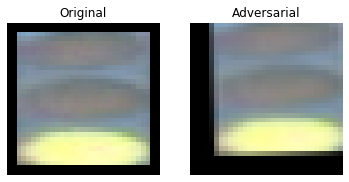

[1, 0, 0]
64


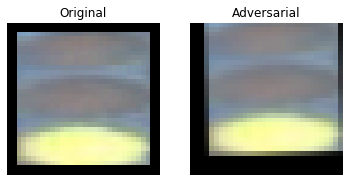

[1, 0, 0]
65


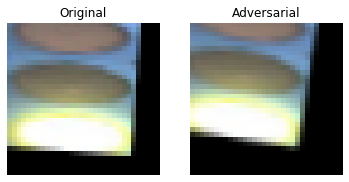

[1, 0, 0]
66


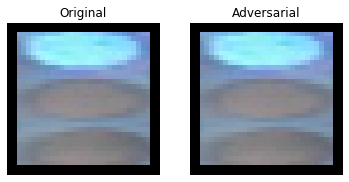

[0, 0, 1]
67


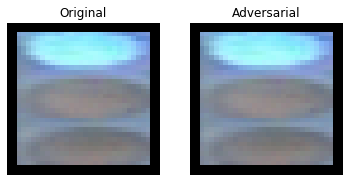

[0, 0, 1]
68


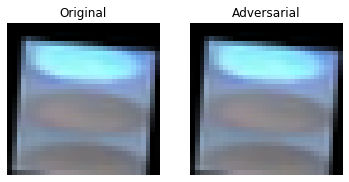

[0, 0, 1]
69


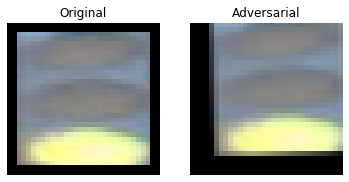

[1, 0, 0]
70


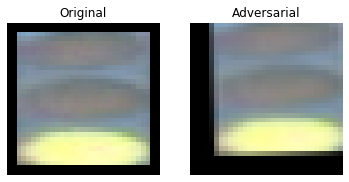

[1, 0, 0]
71


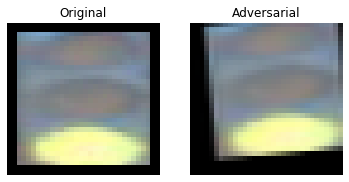

[1, 0, 0]
72


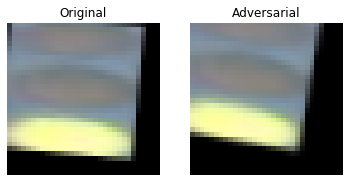

[1, 0, 0]
73


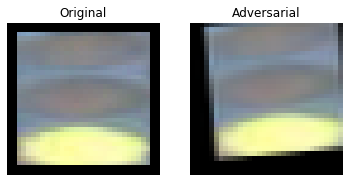

[1, 0, 0]
74


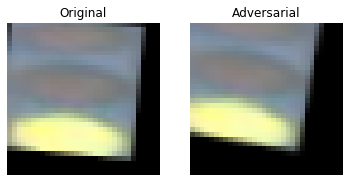

[1, 0, 0]
75


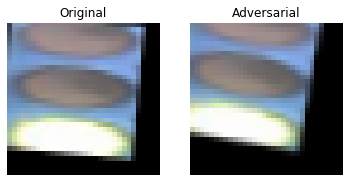

[1, 0, 0]
76


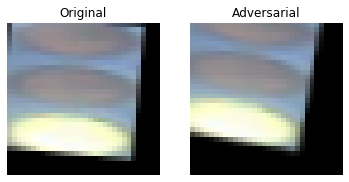

[1, 0, 0]
77


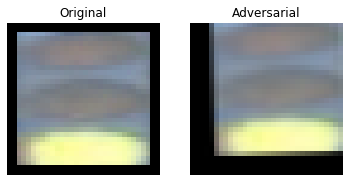

[1, 0, 0]
78


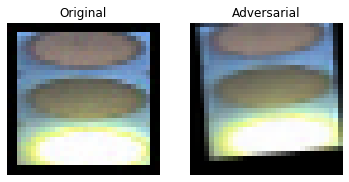

[1, 0, 0]
79


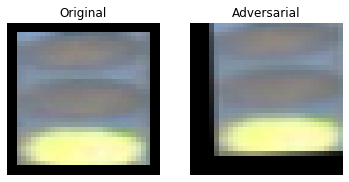

[1, 0, 0]
80


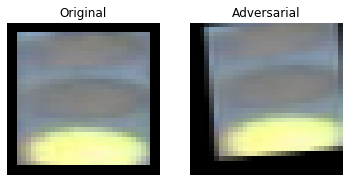

[1, 0, 0]
81


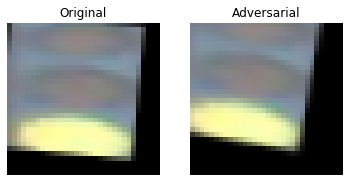

[1, 0, 0]
82


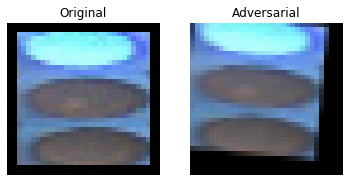

[0, 0, 1]
83


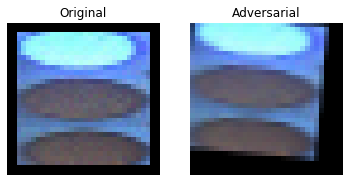

[0, 0, 1]
84


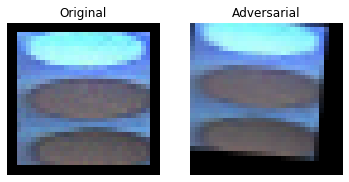

[0, 0, 1]
85


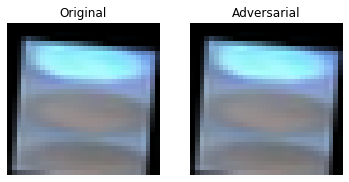

[0, 0, 1]
86


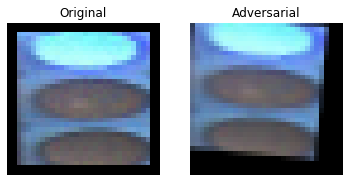

[0, 0, 1]
87


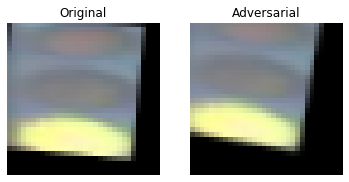

[1, 0, 0]
88


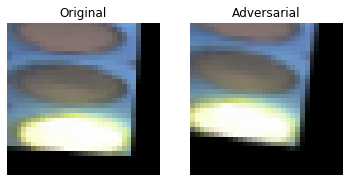

[1, 0, 0]
89


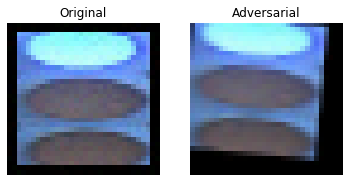

[0, 0, 1]
90


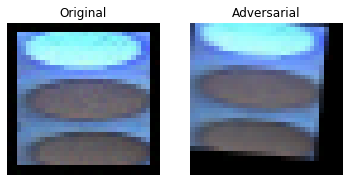

[0, 0, 1]
91


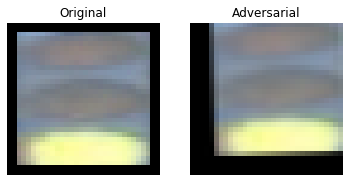

[1, 0, 0]
92


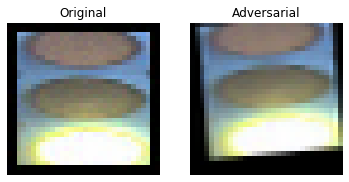

[1, 0, 0]
93


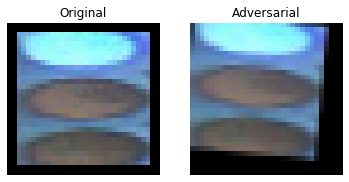

[0, 0, 1]
94


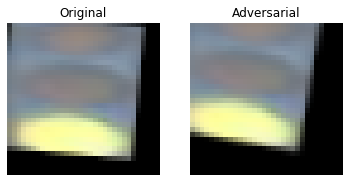

[1, 0, 0]
95


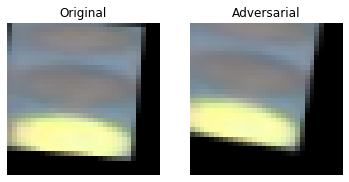

[1, 0, 0]
96


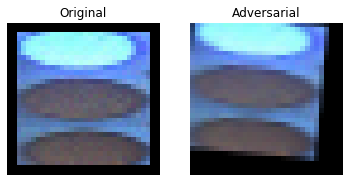

[0, 0, 1]
97


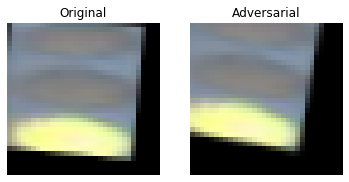

[1, 0, 0]
98


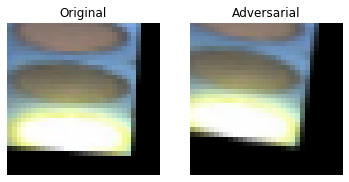

[1, 0, 0]
99


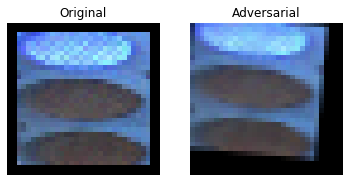

[0, 0, 1]
100


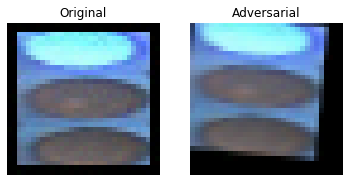

[0, 0, 1]
101


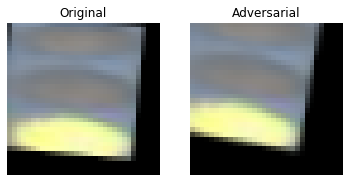

[1, 0, 0]
102


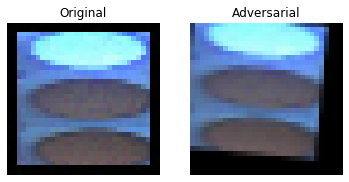

[0, 0, 1]
103


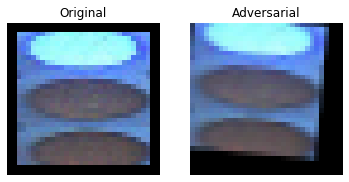

[0, 0, 1]
104


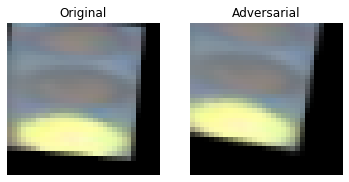

[1, 0, 0]
105


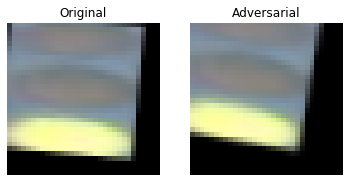

[1, 0, 0]
106


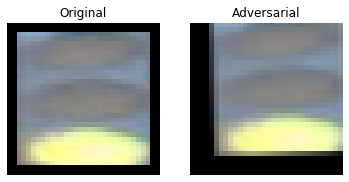

[1, 0, 0]
107


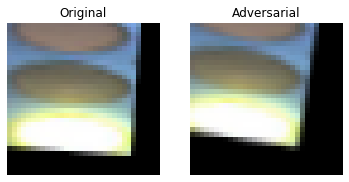

[1, 0, 0]
108


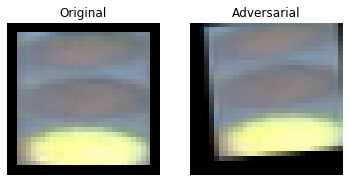

[1, 0, 0]
109


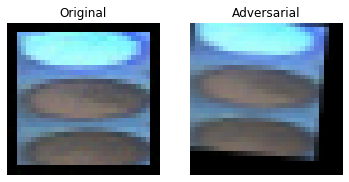

[0, 0, 1]
110


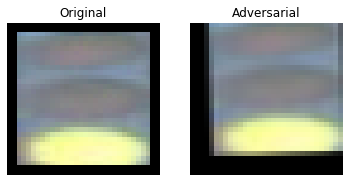

[1, 0, 0]
111


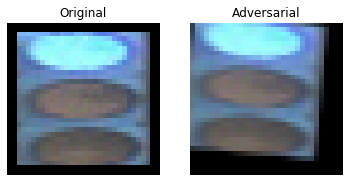

[0, 0, 1]
112


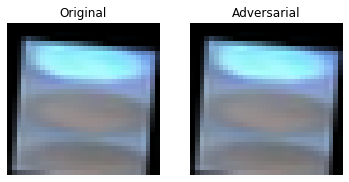

[0, 0, 1]
113


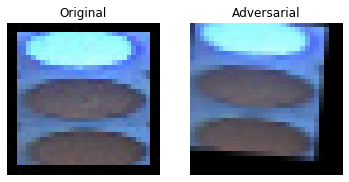

[0, 0, 1]
114


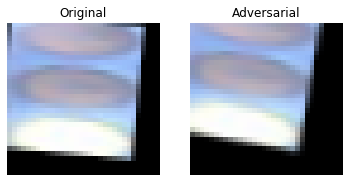

[1, 0, 0]
115


In [0]:
k = 0
count1 = 0
while k < len(adversarial2):
  if np.isnan(adversarial2[k][0][0][0]) == False:
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(X_test_new[k])  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial2[k])  # ::-1 to convert BGR to RGB
    plt.axis('off')


    plt.show()
    print(Y_test_new[k])
    count1 += 1
    print(count1)
  k += 1

  

In [0]:
import foolbox
from foolbox.attacks import CarliniWagnerL2Attack
from foolbox.criteria import TargetClassProbability
test_labels = []
count = 0
while count < len(Y_test_new):
  test_labels.append(np.argmax(Y_test_new[count]))
  count += 1

fmodel = foolbox.models.KerasModel(robust_distilled_model, bounds=(0, 1), preprocessing=(0,1), predicts = 'logits')
attack = foolbox.attacks.CarliniWagnerL2Attack(fmodel)
adversarial2 = attack(test_array_for_model(X_test_new), np.array(test_labels))

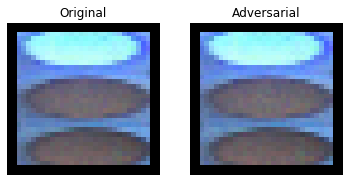

[0, 0, 1]
1


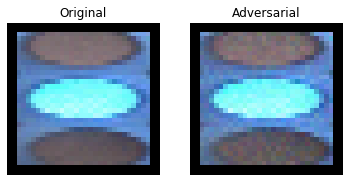

[0, 1, 0]
2


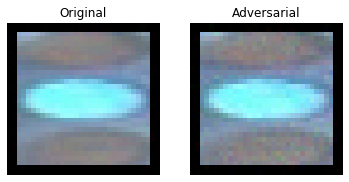

[0, 1, 0]
3


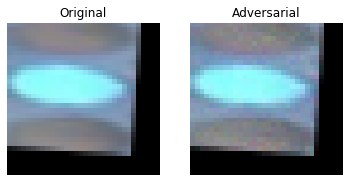

[0, 1, 0]
4


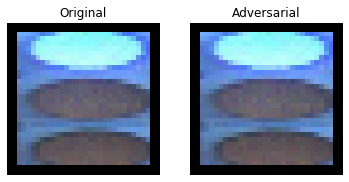

[0, 0, 1]
5


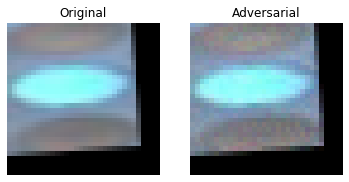

[0, 1, 0]
6


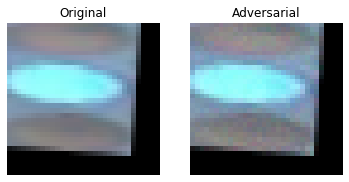

[0, 1, 0]
7


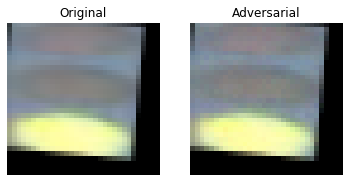

[1, 0, 0]
8


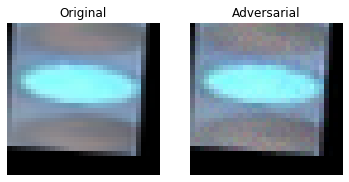

[0, 1, 0]
9


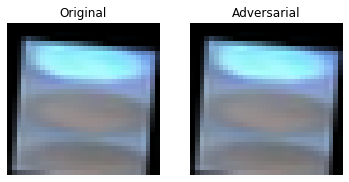

[0, 0, 1]
10


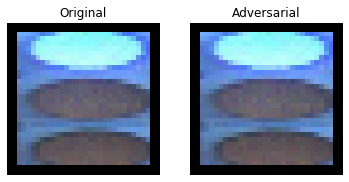

[0, 0, 1]
11


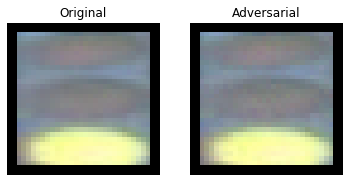

[1, 0, 0]
12


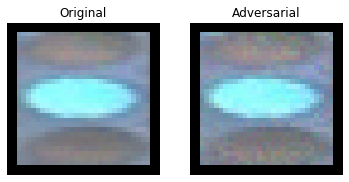

[0, 1, 0]
13


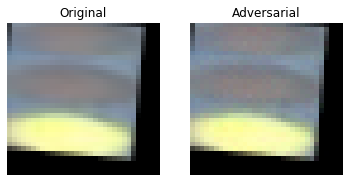

[1, 0, 0]
14


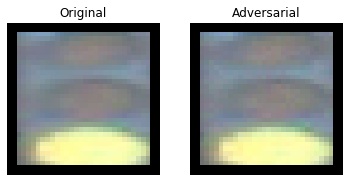

[1, 0, 0]
15


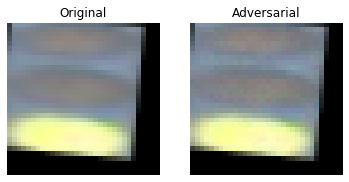

[1, 0, 0]
16


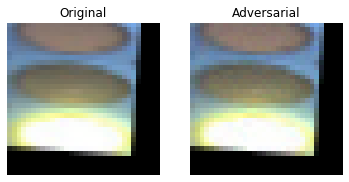

[1, 0, 0]
17


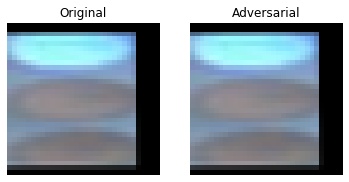

[0, 0, 1]
18


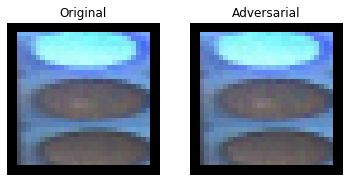

[0, 0, 1]
19


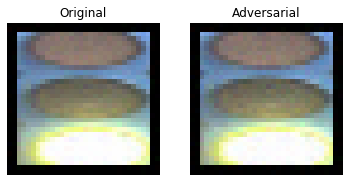

[1, 0, 0]
20


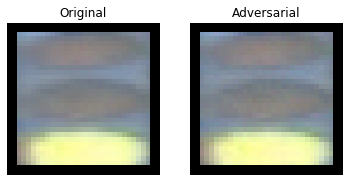

[1, 0, 0]
21


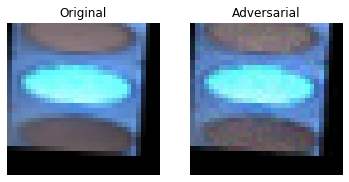

[0, 1, 0]
22


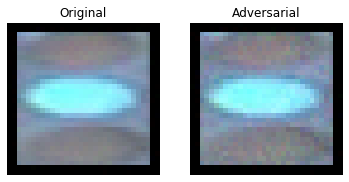

[0, 1, 0]
23


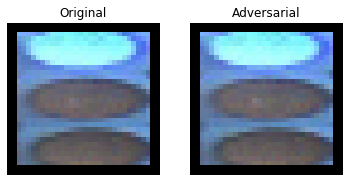

[0, 0, 1]
24


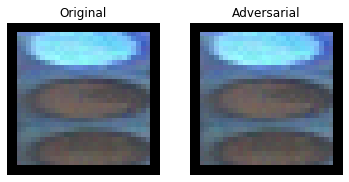

[0, 0, 1]
25


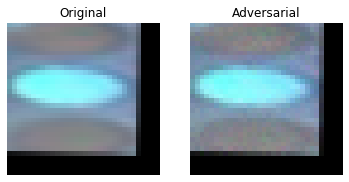

[0, 1, 0]
26


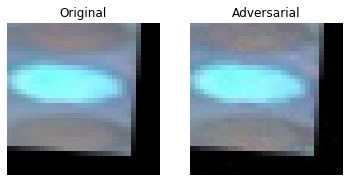

[0, 1, 0]
27


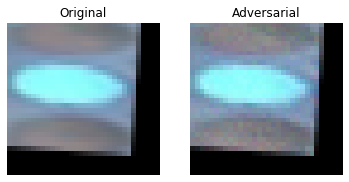

[0, 1, 0]
28


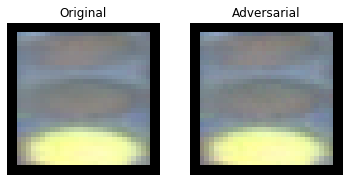

[1, 0, 0]
29


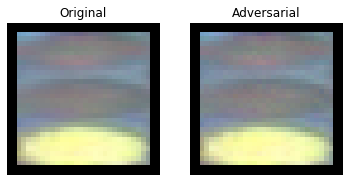

[1, 0, 0]
30


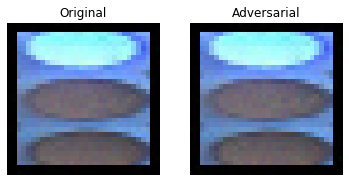

[0, 0, 1]
31


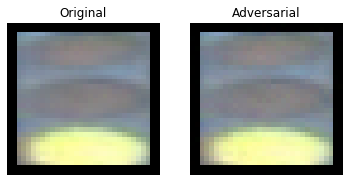

[1, 0, 0]
32


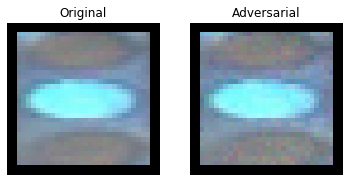

[0, 1, 0]
33


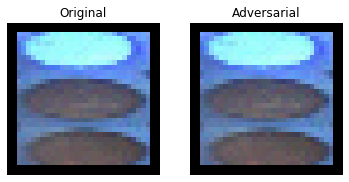

[0, 0, 1]
34


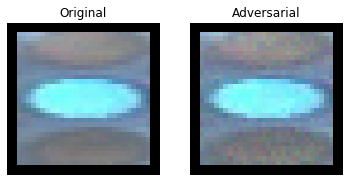

[0, 1, 0]
35


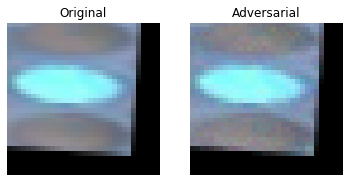

[0, 1, 0]
36


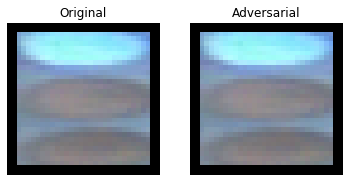

[0, 0, 1]
37


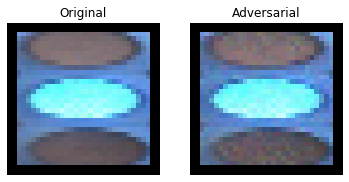

[0, 1, 0]
38


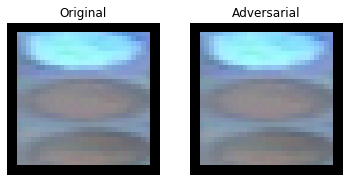

[0, 0, 1]
39


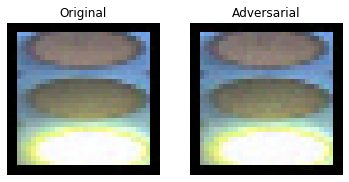

[1, 0, 0]
40


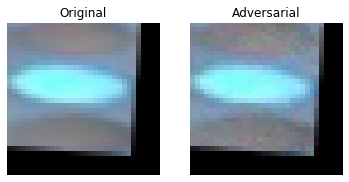

[0, 1, 0]
41


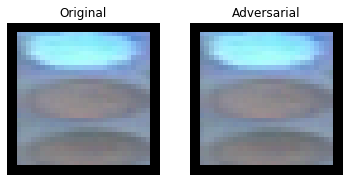

[0, 0, 1]
42


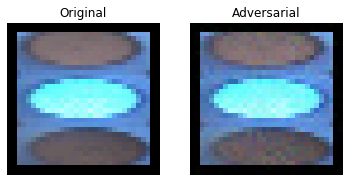

[0, 1, 0]
43


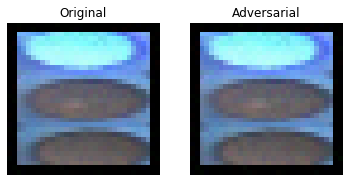

[0, 0, 1]
44


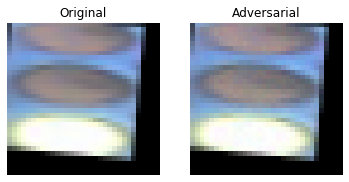

[1, 0, 0]
45


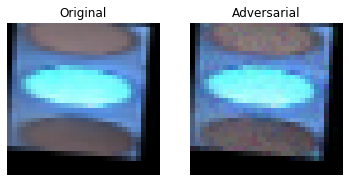

[0, 1, 0]
46


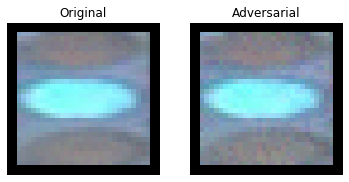

[0, 1, 0]
47


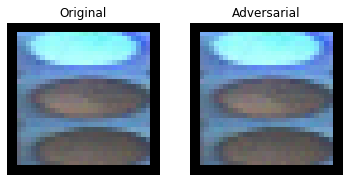

[0, 0, 1]
48


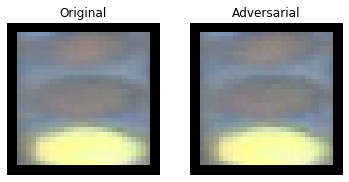

[1, 0, 0]
49


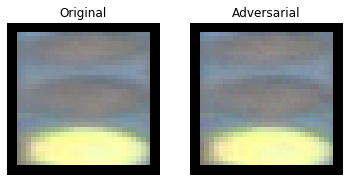

[1, 0, 0]
50


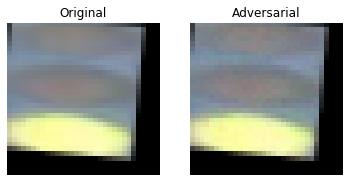

[1, 0, 0]
51


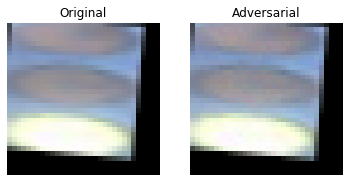

[1, 0, 0]
52


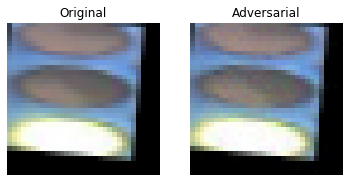

[1, 0, 0]
53


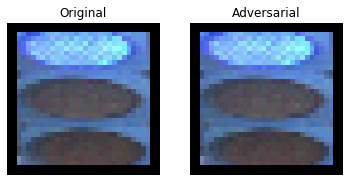

[0, 0, 1]
54


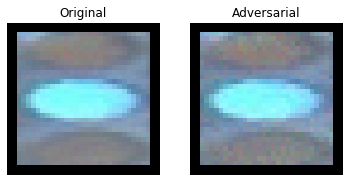

[0, 1, 0]
55


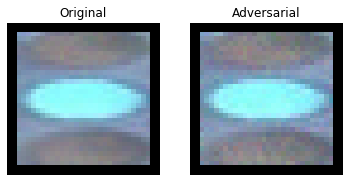

[0, 1, 0]
56


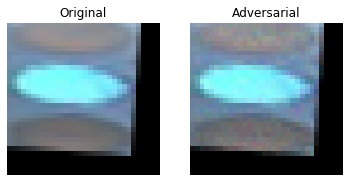

[0, 1, 0]
57


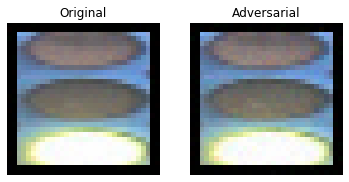

[1, 0, 0]
58


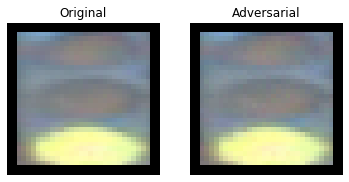

[1, 0, 0]
59


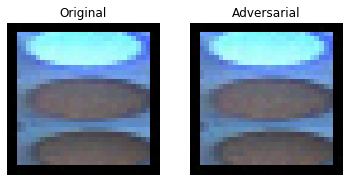

[0, 0, 1]
60


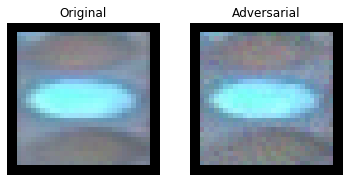

[0, 1, 0]
61


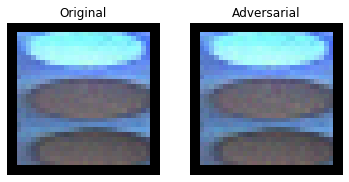

[0, 0, 1]
62


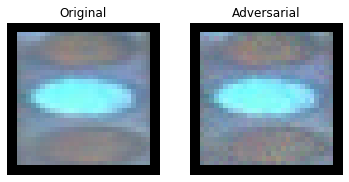

[0, 1, 0]
63


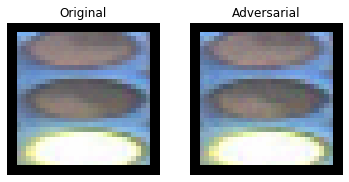

[1, 0, 0]
64


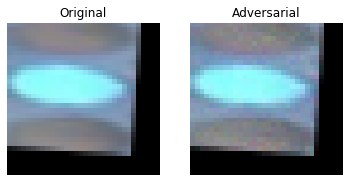

[0, 1, 0]
65


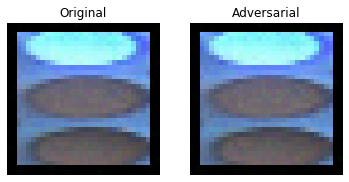

[0, 0, 1]
66


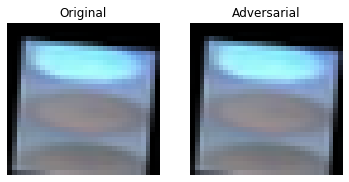

[0, 0, 1]
67


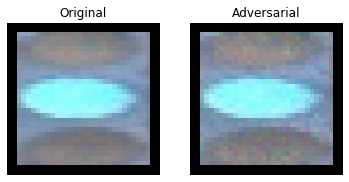

[0, 1, 0]
68


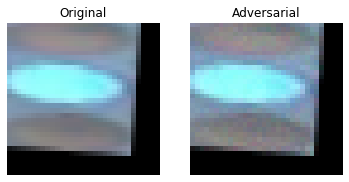

[0, 1, 0]
69


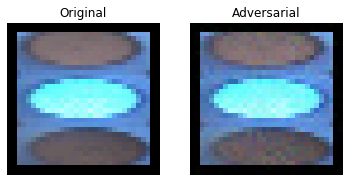

[0, 1, 0]
70


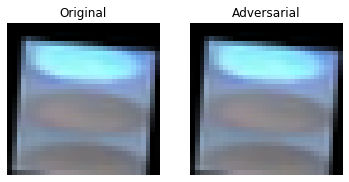

[0, 0, 1]
71


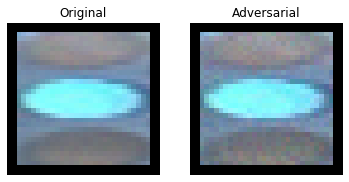

[0, 1, 0]
72


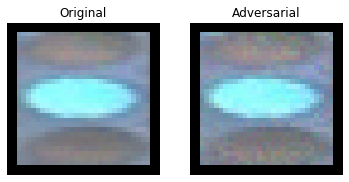

[0, 1, 0]
73


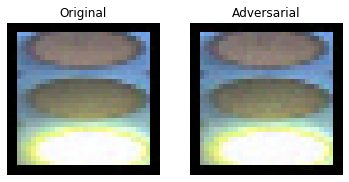

[1, 0, 0]
74


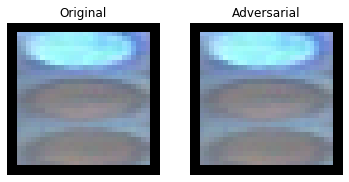

[0, 0, 1]
75


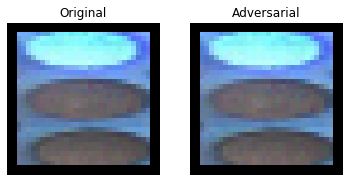

[0, 0, 1]
76


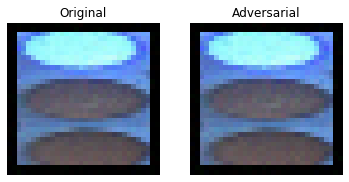

[0, 0, 1]
77


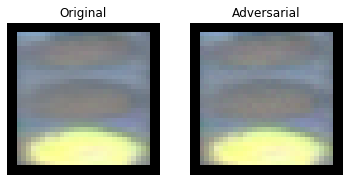

[1, 0, 0]
78


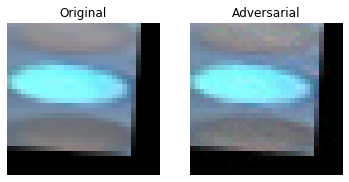

[0, 1, 0]
79


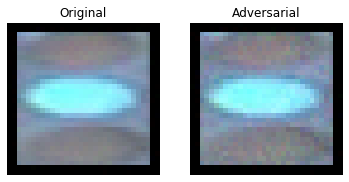

[0, 1, 0]
80


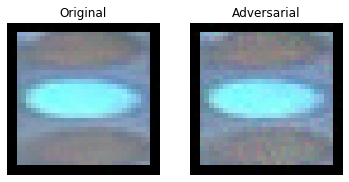

[0, 1, 0]
81


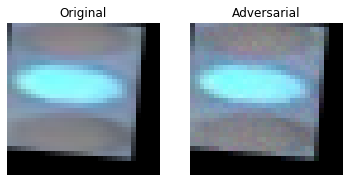

[0, 1, 0]
82


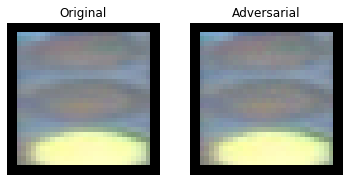

[1, 0, 0]
83


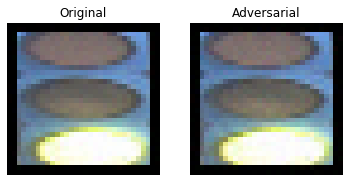

[1, 0, 0]
84


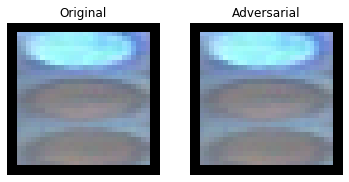

[0, 0, 1]
85


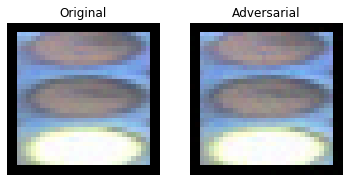

[1, 0, 0]
86


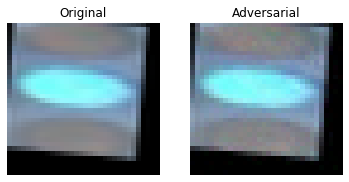

[0, 1, 0]
87


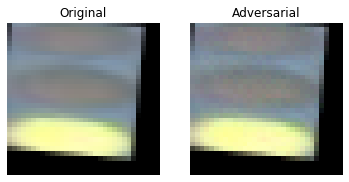

[1, 0, 0]
88


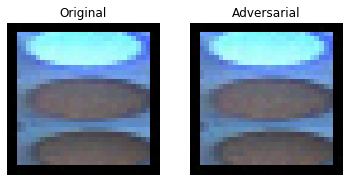

[0, 0, 1]
89


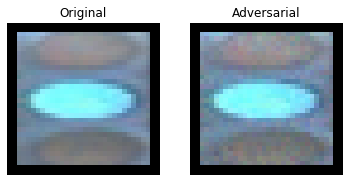

[0, 1, 0]
90


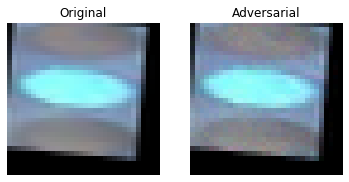

[0, 1, 0]
91


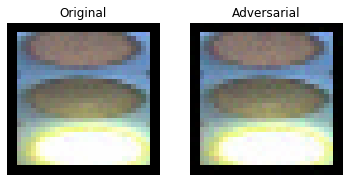

[1, 0, 0]
92


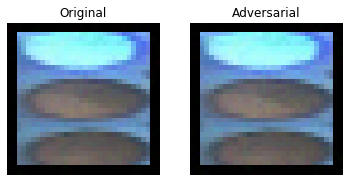

[0, 0, 1]
93


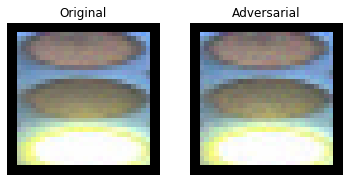

[1, 0, 0]
94


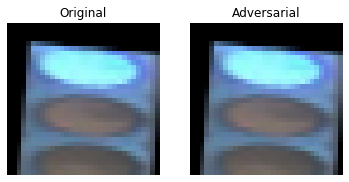

[0, 0, 1]
95


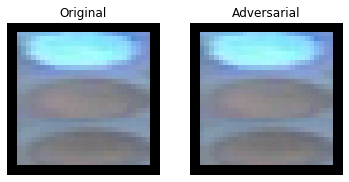

[0, 0, 1]
96


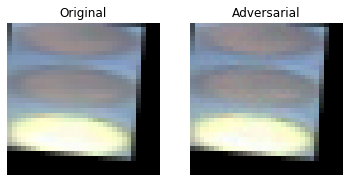

[1, 0, 0]
97


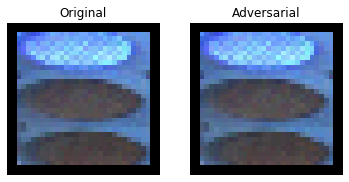

[0, 0, 1]
98


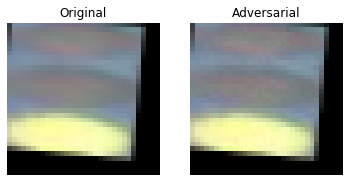

[1, 0, 0]
99


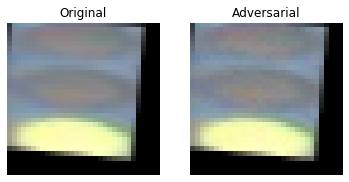

[1, 0, 0]
100


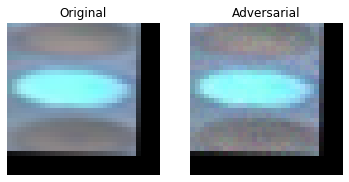

[0, 1, 0]
101


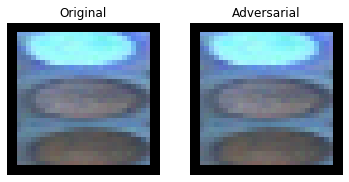

[0, 0, 1]
102


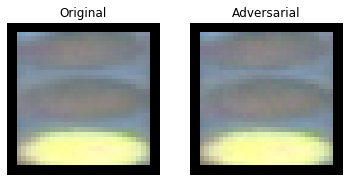

[1, 0, 0]
103


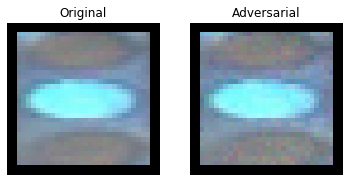

[0, 1, 0]
104


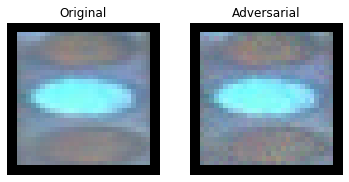

[0, 1, 0]
105


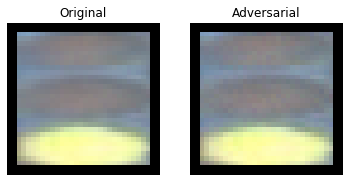

[1, 0, 0]
106


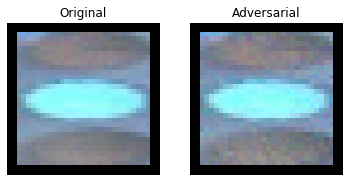

[0, 1, 0]
107


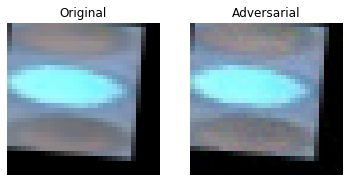

[0, 1, 0]
108


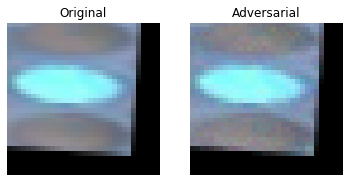

[0, 1, 0]
109


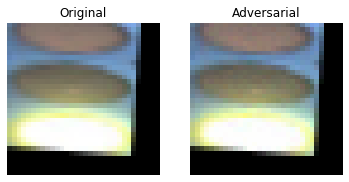

[1, 0, 0]
110


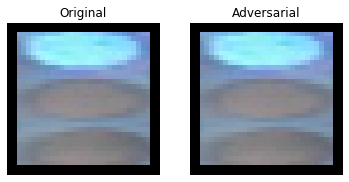

[0, 0, 1]
111


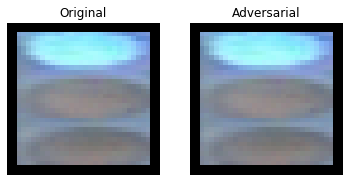

[0, 0, 1]
112


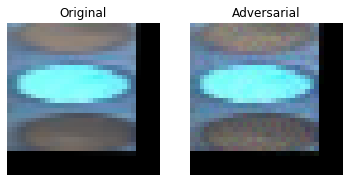

[0, 1, 0]
113


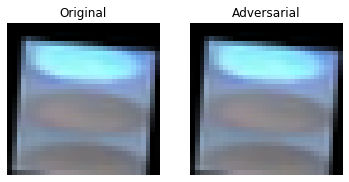

[0, 0, 1]
114


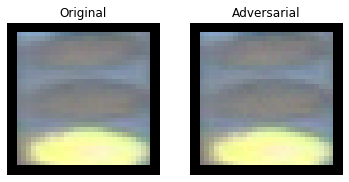

[1, 0, 0]
115


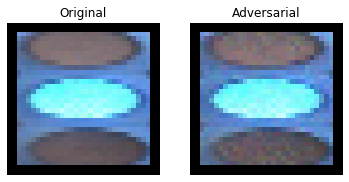

[0, 1, 0]
116


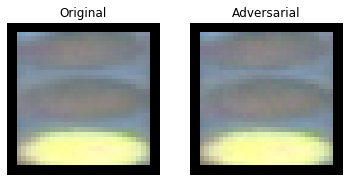

[1, 0, 0]
117


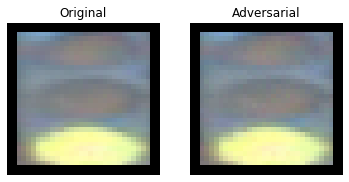

[1, 0, 0]
118


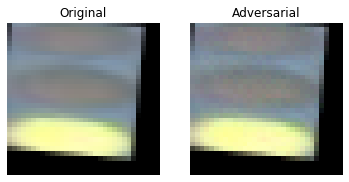

[1, 0, 0]
119


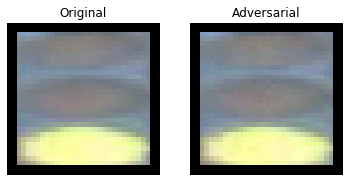

[1, 0, 0]
120


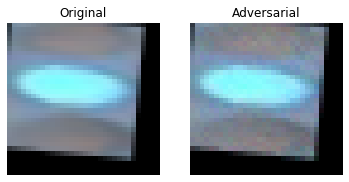

[0, 1, 0]
121


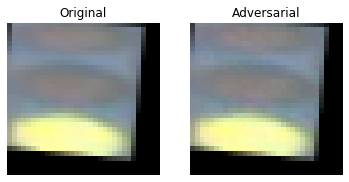

[1, 0, 0]
122


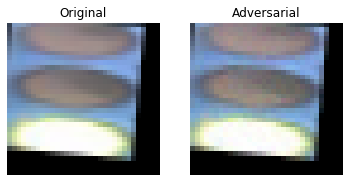

[1, 0, 0]
123


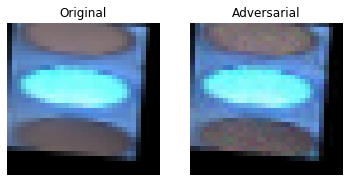

[0, 1, 0]
124


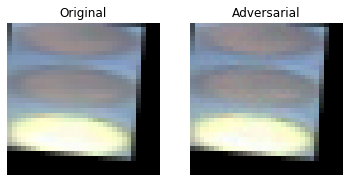

[1, 0, 0]
125


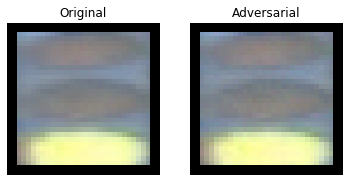

[1, 0, 0]
126


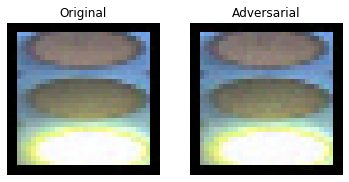

[1, 0, 0]
127


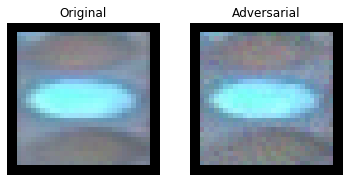

[0, 1, 0]
128


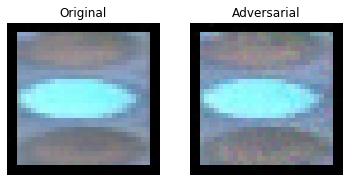

[0, 1, 0]
129


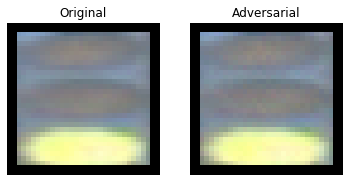

[1, 0, 0]
130


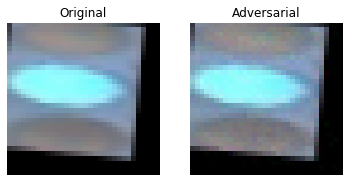

[0, 1, 0]
131


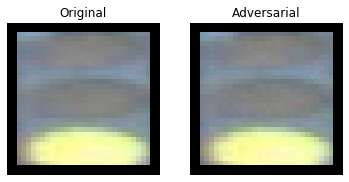

[1, 0, 0]
132


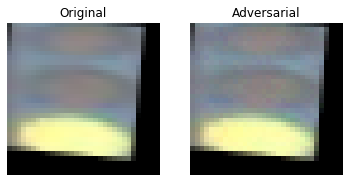

[1, 0, 0]
133


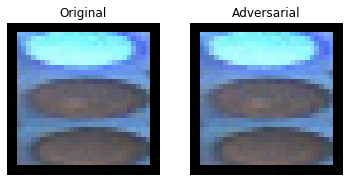

[0, 0, 1]
134


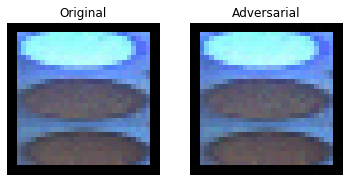

[0, 0, 1]
135


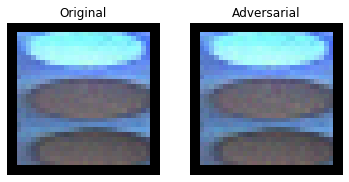

[0, 0, 1]
136


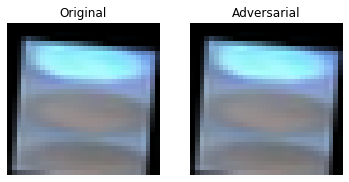

[0, 0, 1]
137


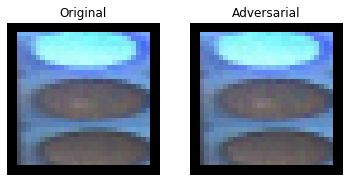

[0, 0, 1]
138


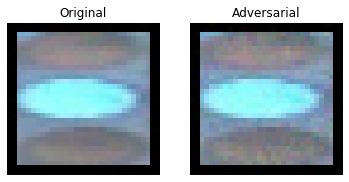

[0, 1, 0]
139


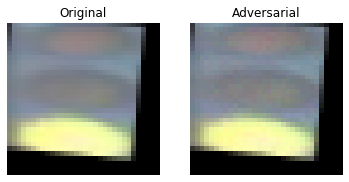

[1, 0, 0]
140


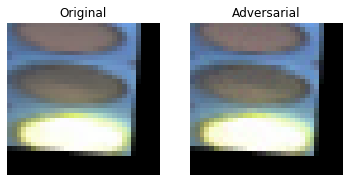

[1, 0, 0]
141


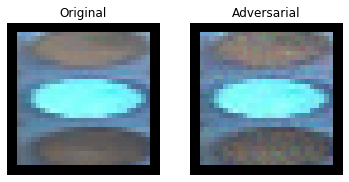

[0, 1, 0]
142


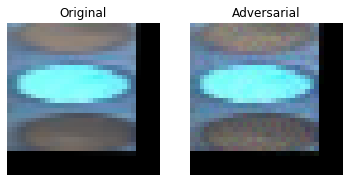

[0, 1, 0]
143


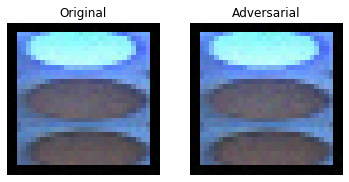

[0, 0, 1]
144


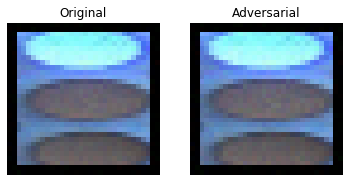

[0, 0, 1]
145


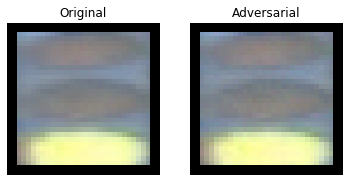

[1, 0, 0]
146


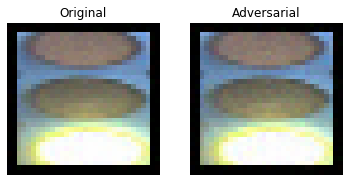

[1, 0, 0]
147


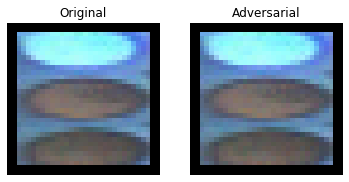

[0, 0, 1]
148


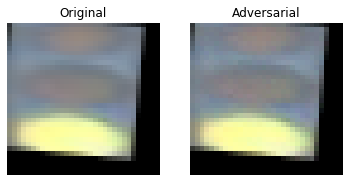

[1, 0, 0]
149


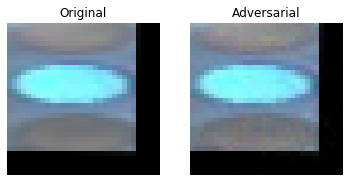

[0, 1, 0]
150


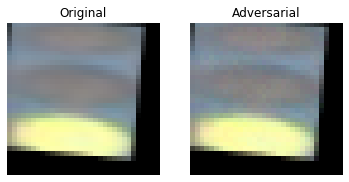

[1, 0, 0]
151


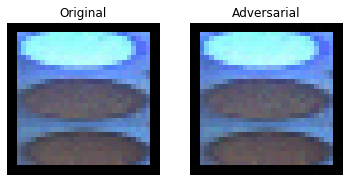

[0, 0, 1]
152


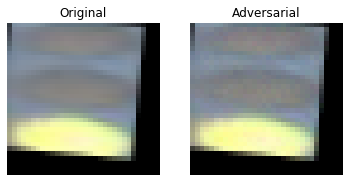

[1, 0, 0]
153


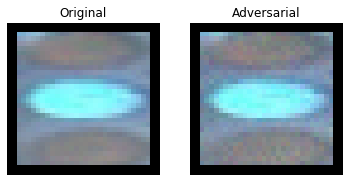

[0, 1, 0]
154


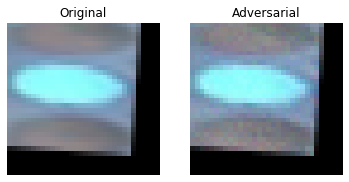

[0, 1, 0]
155


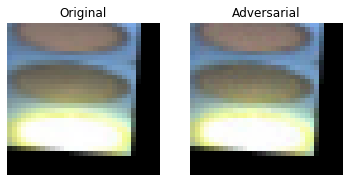

[1, 0, 0]
156


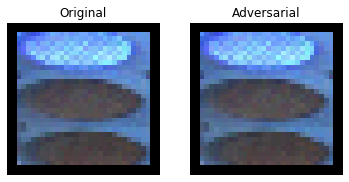

[0, 0, 1]
157


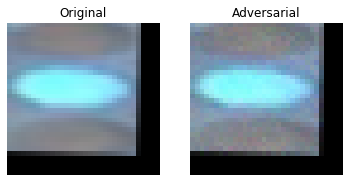

[0, 1, 0]
158


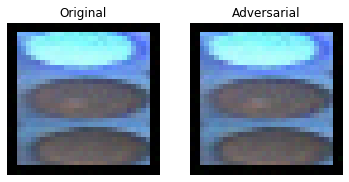

[0, 0, 1]
159


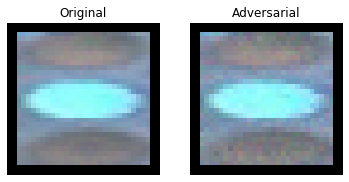

[0, 1, 0]
160


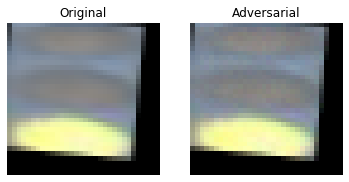

[1, 0, 0]
161


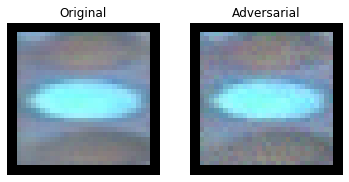

[0, 1, 0]
162


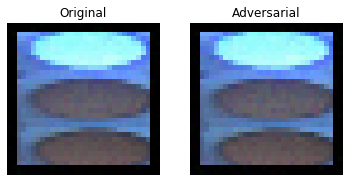

[0, 0, 1]
163


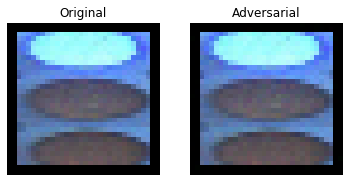

[0, 0, 1]
164


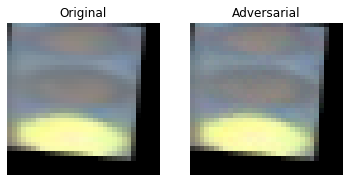

[1, 0, 0]
165


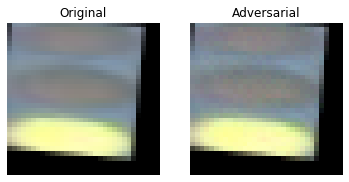

[1, 0, 0]
166


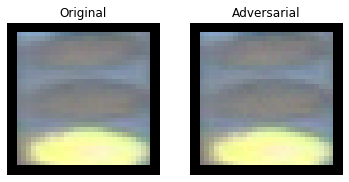

[1, 0, 0]
167


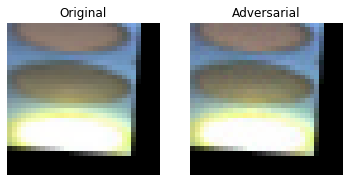

[1, 0, 0]
168


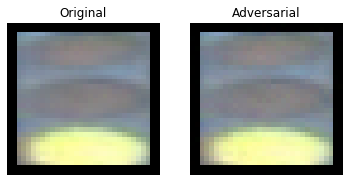

[1, 0, 0]
169


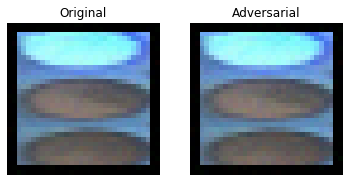

[0, 0, 1]
170


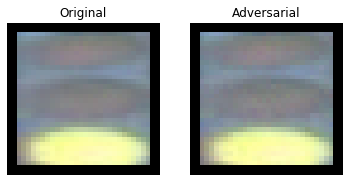

[1, 0, 0]
171


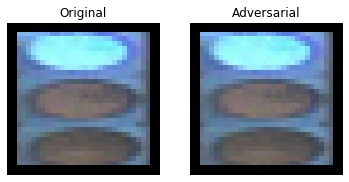

[0, 0, 1]
172


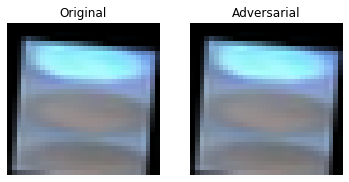

[0, 0, 1]
173


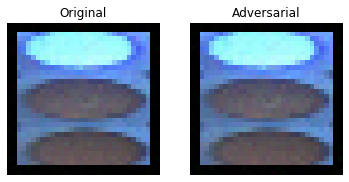

[0, 0, 1]
174


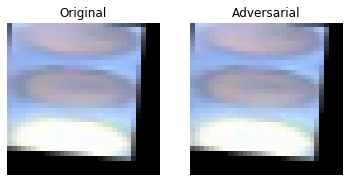

[1, 0, 0]
175


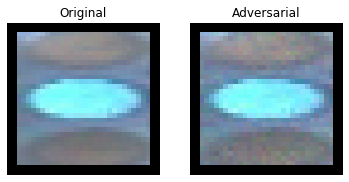

[0, 1, 0]
176


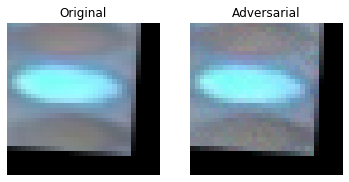

[0, 1, 0]
177


In [0]:
k = 0
count1 = 0
while k < len(adversarial2):
  if np.isnan(adversarial2[k][0][0][0]) == False:
    plt.figure()

    plt.subplot(1, 2, 1)
    plt.title('Original')
    plt.imshow(X_test_new[k])  # division by 255 to convert [0, 255] to [0, 1]
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Adversarial')
    plt.imshow(adversarial2[k])  # ::-1 to convert BGR to RGB
    plt.axis('off')


    plt.show()
    print(Y_test_new[k])
    count1 += 1
    print(count1)
  k += 1
